# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = 'results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_3df_res.pkl',
 'ancova_perm_res.pkl',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'chimp_clusters_ancova.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

## Specie-specific genes

In [11]:
model_res = pd.read_csv('results/gene_selection_df.csv', index_col=0)
model_res.head()

human     chimp   macaque
AACS   0.001206  0.014287  0.318736
AAGAB  0.731575  0.661344  0.024143
AAK1   0.000658  0.699175  0.069657
AAMP   0.762617  0.530339  0.947528
AAR2   0.312623  0.436571  0.343371

In [12]:
import pickle
with open("results/ancova_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [13]:
# import pickle
# with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
#     genes_dict77 = pickle.load(file)

In [14]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in ancova_results.items()}
sign_genes

{'human-chimp': Index(['AAK1', 'ABCC10', 'ABCC5', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTN2', 'ADORA1',
        'AGFG1', 'AHI1',
        ...
        'ZBTB14', 'ZBTB17', 'ZBTB46', 'ZFP37', 'ZFPL1', 'ZMAT2', 'ZMYM2',
        'ZMYND8', 'ZNF608', 'ZNF692'],
       dtype='object', length=385),
 'human-macaque': Index(['AAK1', 'AATK', 'ABTB1', 'ACSBG1', 'ACSL1', 'ACVR1B', 'ADAM11',
        'ADGRB2', 'ADPRS', 'AFDN',
        ...
        'YARS1', 'YWHAE', 'ZBTB18', 'ZBTB46', 'ZFP90', 'ZMYND11', 'ZMYND8',
        'ZNF330', 'ZNF33A', 'ZNF827'],
       dtype='object', length=660),
 'chimp-human': Index(['ABCG4', 'ACSL1', 'ACSS2', 'ACTN2', 'ADORA1', 'AHNAK2', 'AK1', 'AK2',
        'AKAP7', 'AKT3',
        ...
        'WDR37', 'WDR45', 'WDR83', 'ZBTB17', 'ZBTB46', 'ZFAND2B', 'ZFP37',
        'ZMYND8', 'ZNF689', 'ZNF692'],
       dtype='object', length=325),
 'chimp-macaque': Index(['ABCD3', 'ACAD9', 'ACOT13', 'ACTG1', 'ACTN2', 'ADAM19', 'ADGRB1',
        'ADPGK', 'AK5', 'AKAP7',
        ...
        'WIF1',

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [15]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes

Index(['AAK1', 'ACSL1', 'AHI1', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2', 'ARHGAP12',
       'ARHGEF1', 'ASPHD2',
       ...
       'TMEM59L', 'TPD52L1', 'TSC22D1', 'USP9X', 'VAT1L', 'VGLL4', 'VPS51',
       'XPNPEP1', 'YWHAE', 'ZBTB46'],
      dtype='object', length=128)

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [19]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [20]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


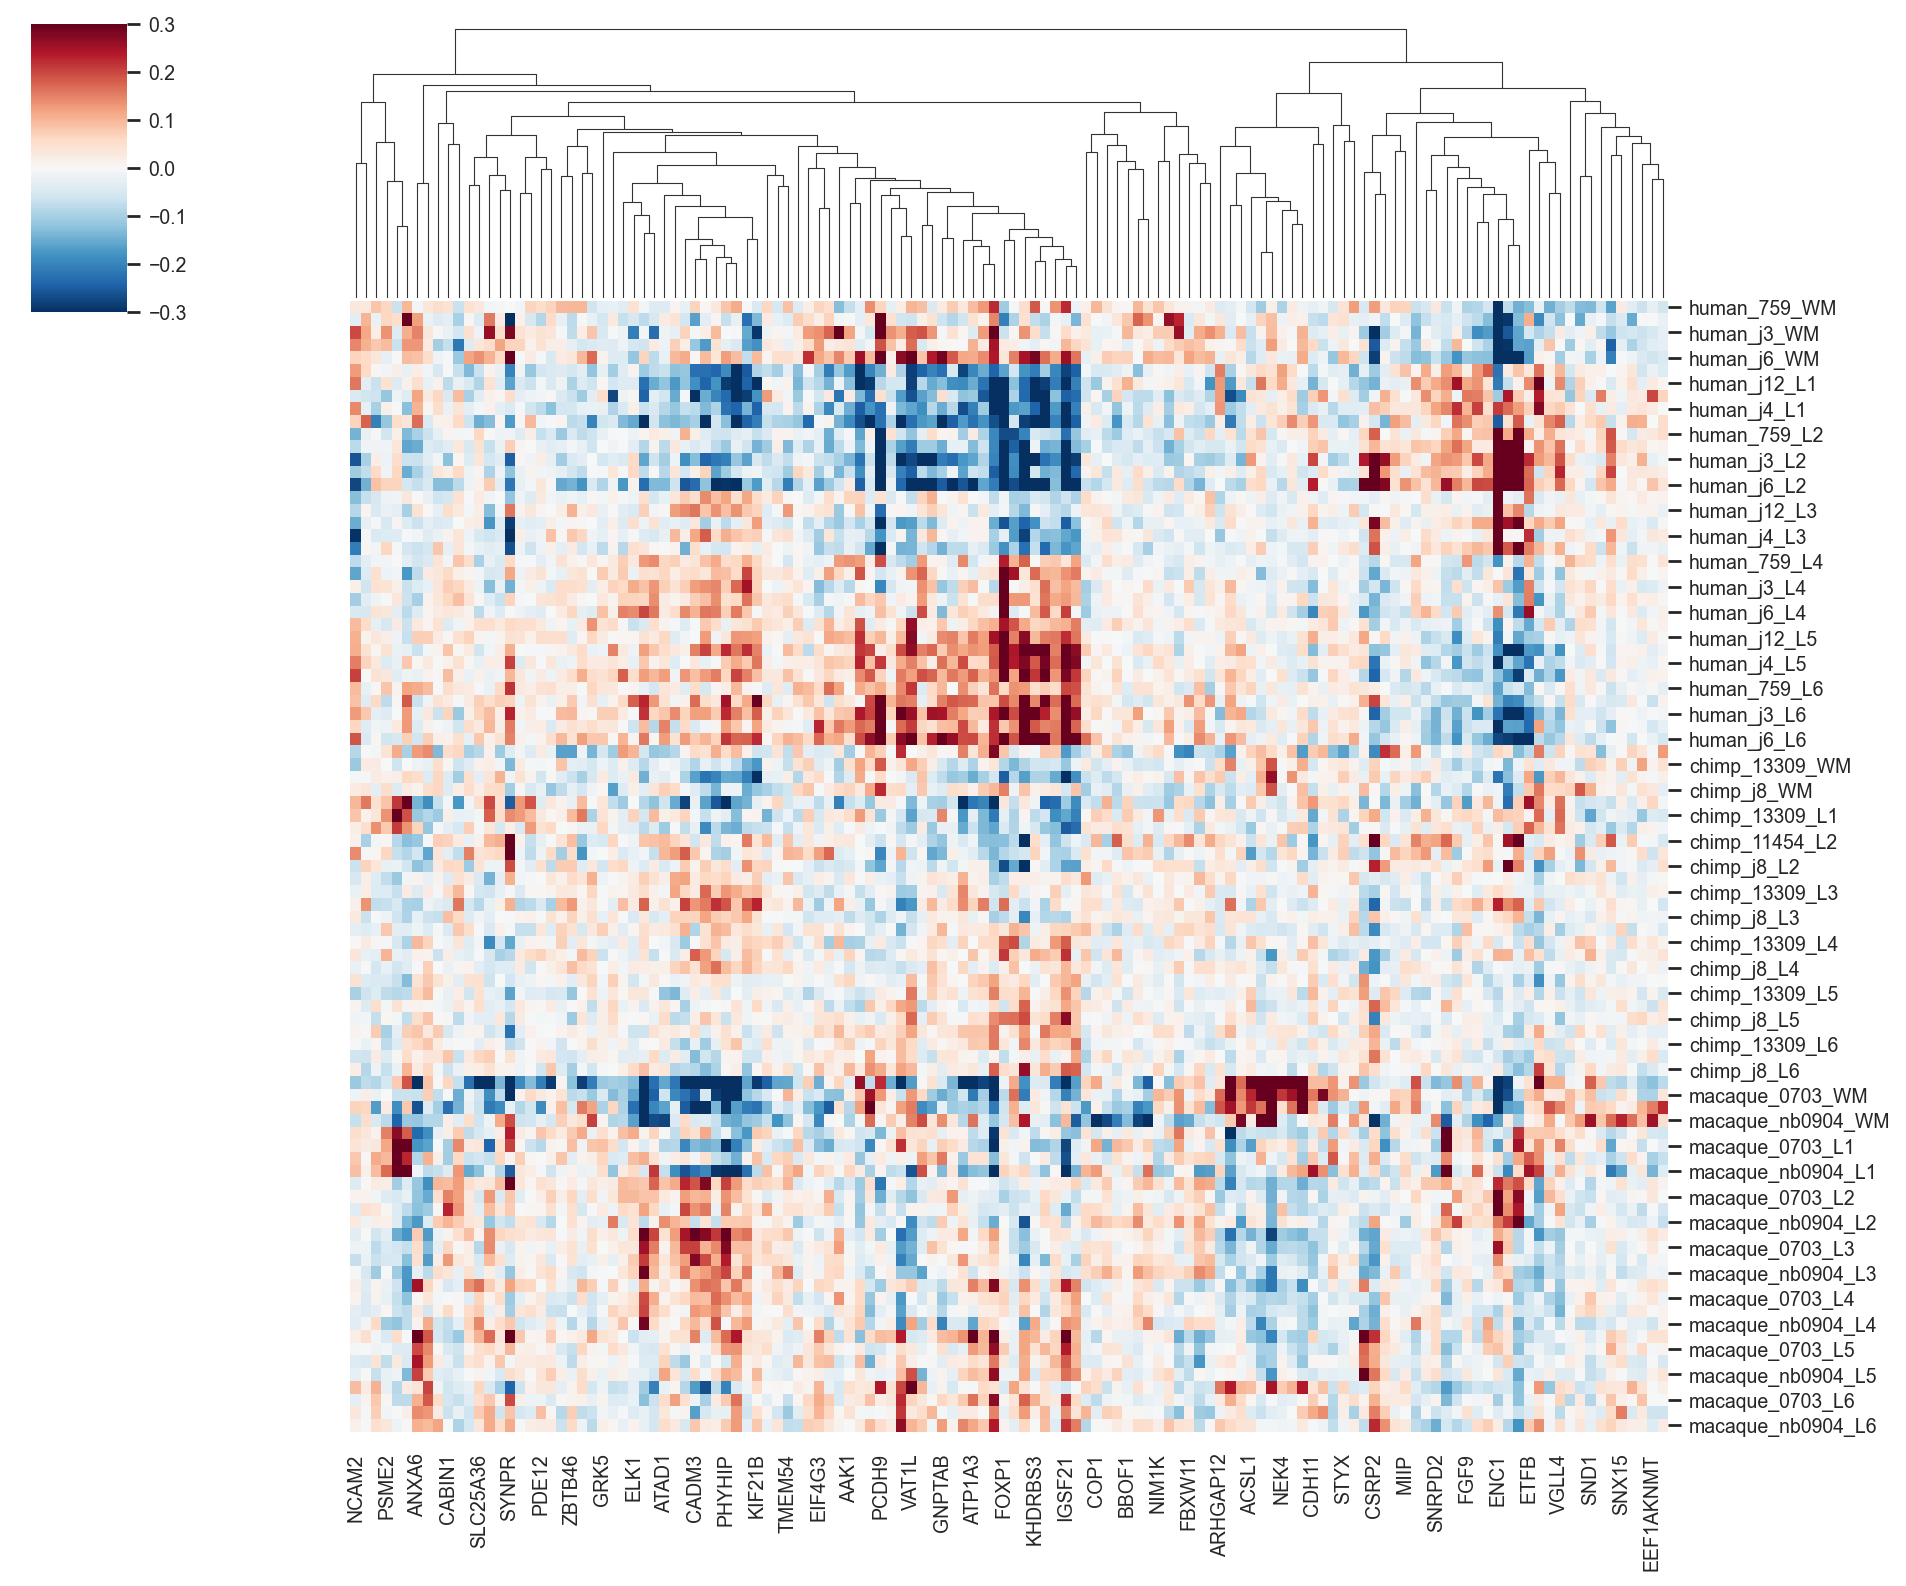

In [21]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [22]:
sns.clustermap(df_hs.loc[sample_order['human']], figsize=(12, 4), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [23]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
#aff_matrix = pairwise_kernels(df_hs.T, metric='cosine') + 1
n_clusters = 6
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
#clustering.fit(aff_matrix)
clustering.fit(df_hs.T[sample_order['human']])

SpectralClustering(affinity='nearest_neighbors', n_clusters=6, random_state=4)

In [24]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [25]:
labels.to_csv('./results/human_clusters_ancova.csv')

In [26]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [27]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

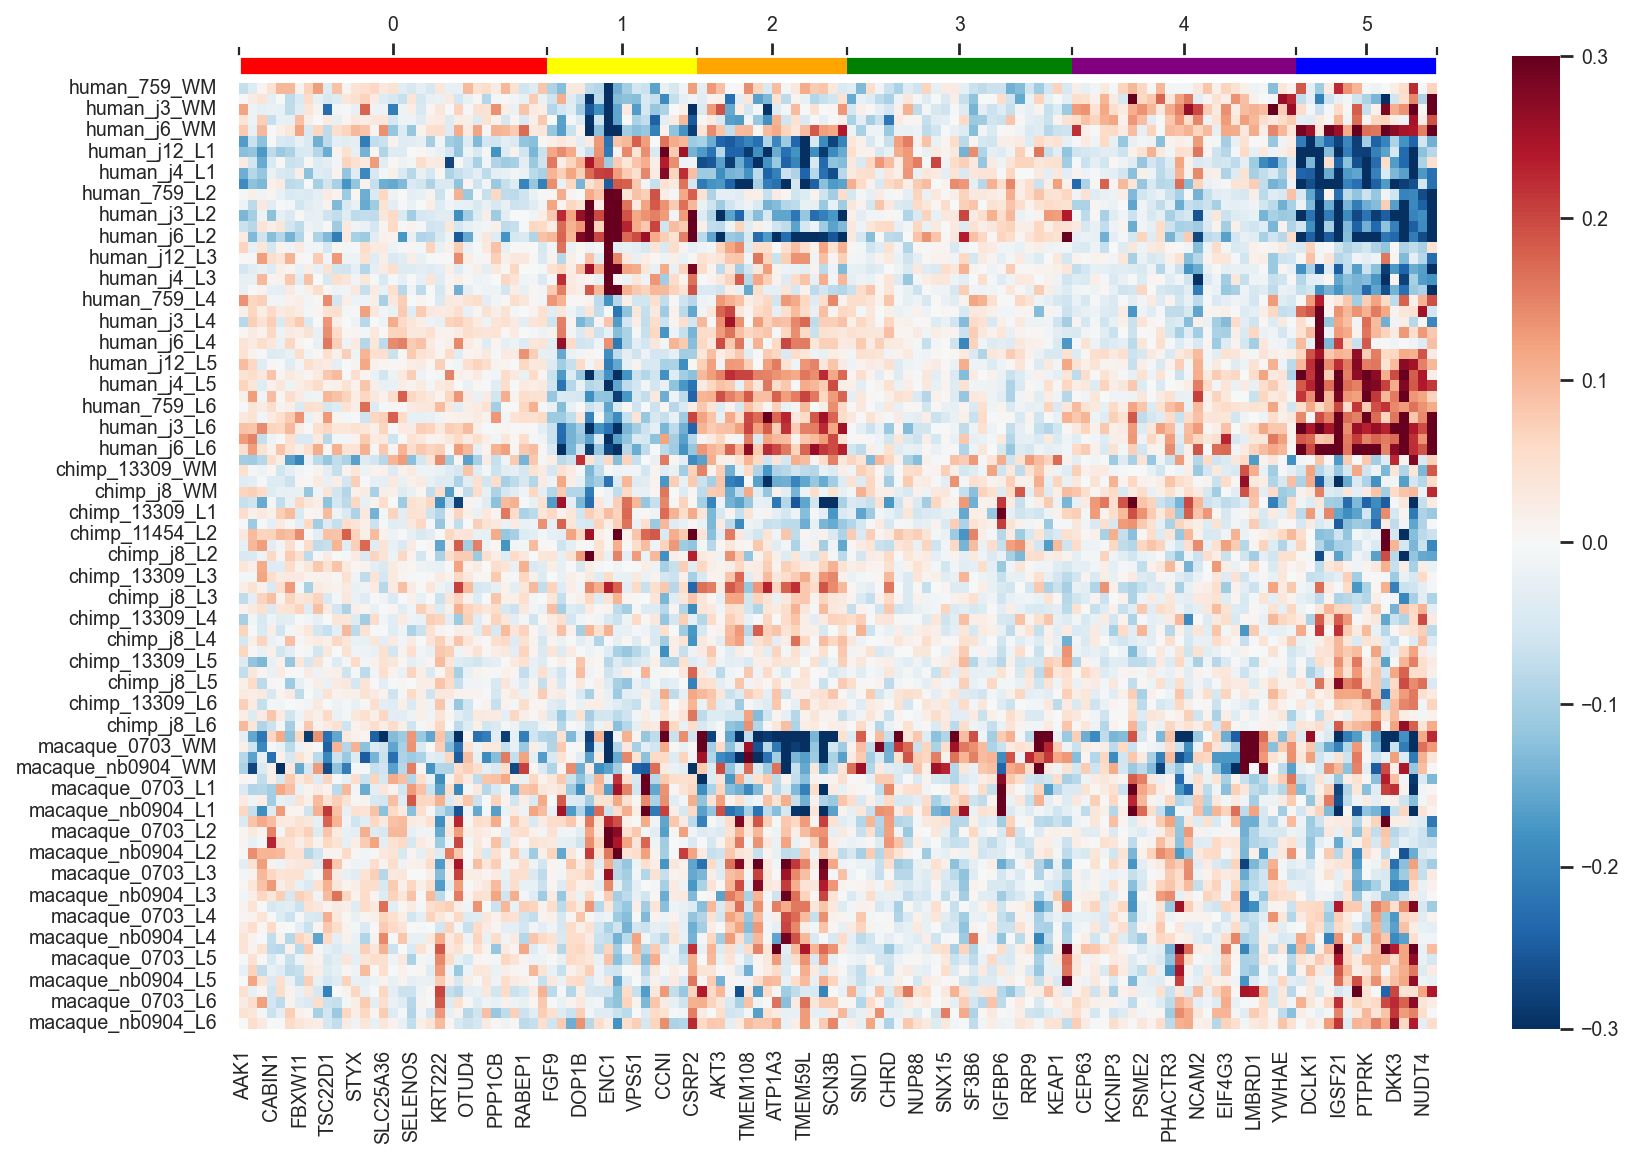

In [28]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [29]:
labels[labels == 1].size

16

## Cluster profiles

In [30]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [31]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

AAK1     ACSL1      AHI1      AKT3     ALCAM     ANXA6  \
condition layer                                                               
chimp     L1    -0.005820 -0.015967  0.027911 -0.012988  0.009130 -0.061217   
          L2    -0.014660 -0.071008  0.021247 -0.013202 -0.242804 -0.096782   
          L3    -0.007055 -0.022306 -0.041518  0.004795 -0.066325 -0.037331   
          L4    -0.018464  0.019382 -0.006365 -0.005160  0.006249  0.023248   
          L5    -0.007488  0.054718 -0.030773 -0.032334  0.134409  0.042378   

                    APBB2  ARHGAP12   ARHGEF1    ASPHD2  ...   TMEM59L  \
condition layer                                          ...             
chimp     L1     0.000521  0.015205  0.020593 -0.042072  ... -0.143562   
          L2     0.009758  0.050214 -0.012653  0.058669  ... -0.011356   
          L3     0.064595 -0.031278 -0.013510  0.078975  ...  0.074531   
          L4     0.065062 -0.014705 -0.027098  0.005267  ...  0.034858   
          L5    -0.020785 -0.010368  0.001988 -0.057243  ...  0.013617   

                  TPD52L1   TSC22D1     USP9X     VAT1L     VGLL4     VPS51  \
condition layer                                                               
chimp     L1    -0.020151 -0.022536 -0.025024 -0.134595  0.167036  0.023511   
          L2     0.081410  0.014389 -0.037757 -0.027984 -0.005204  0.087736   
          L3    -0.017722  0.008030  0.046551 -0.090556 -0.011697  0.021849   
          L4    -0.010822 -0.006805  0.008311 -0.019777 -0.033863  0.004273   
          L5    -0.008715  0.004543 -0.002834  0.138460 -0.070231 -0.040454   

                  XPNPEP1     YWHAE    ZBTB46  
condition layer                                
chimp     L1     0.032094 -0.043822  0.026107  
          L2    -0.008427  0.006897  0.072883  
          L3    -0.000876  0.031802  0.070541  
          L4     0.001779  0.006790  0.024286  
          L5    -0.010013  0.007214 -0.064324  

[5 rows x 128 columns]

In [32]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

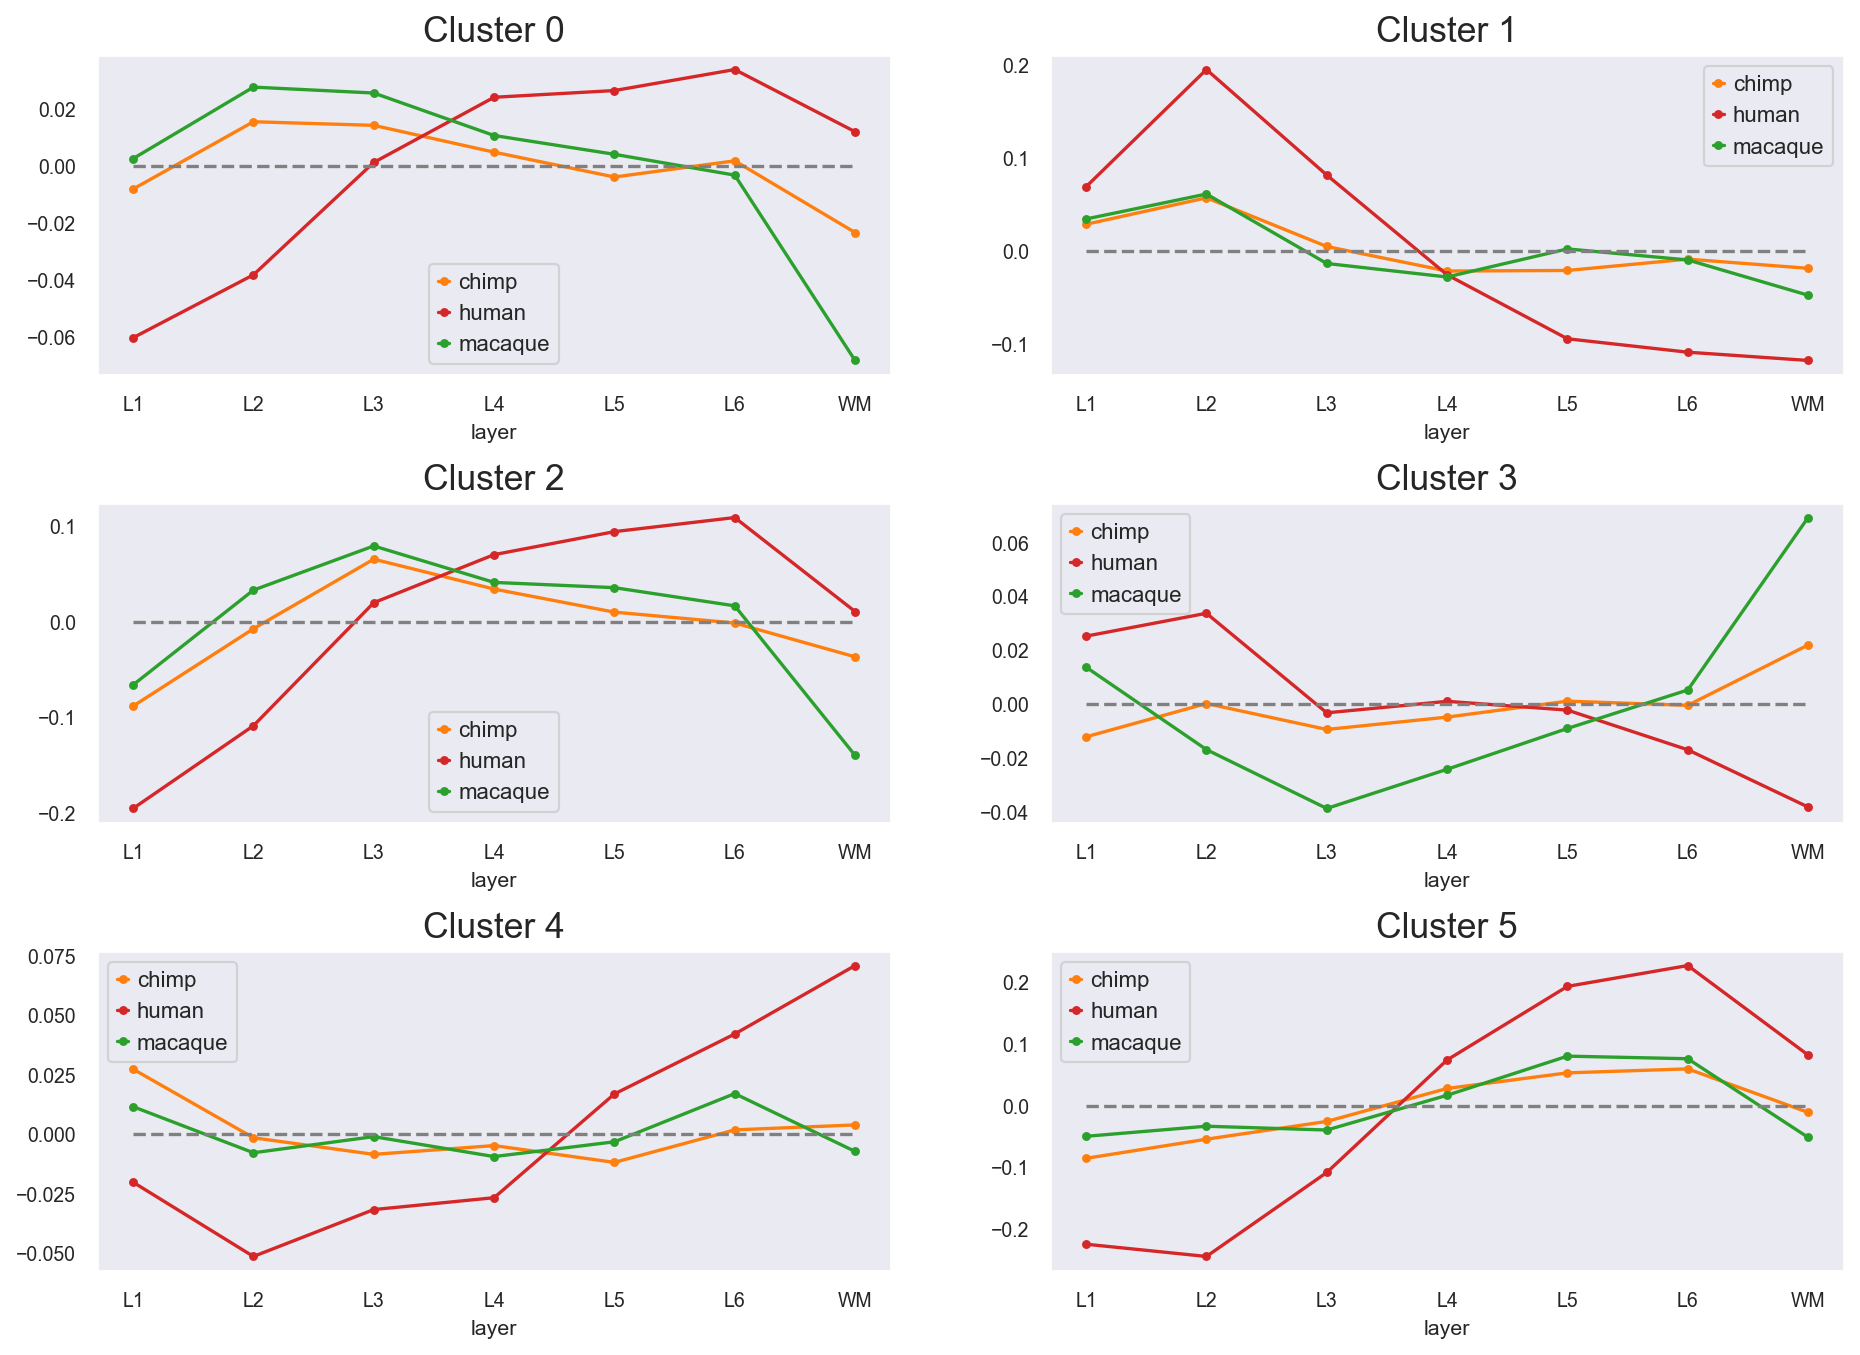

In [33]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

Text(0.5, 0.98, 'Median everaging for profiles')

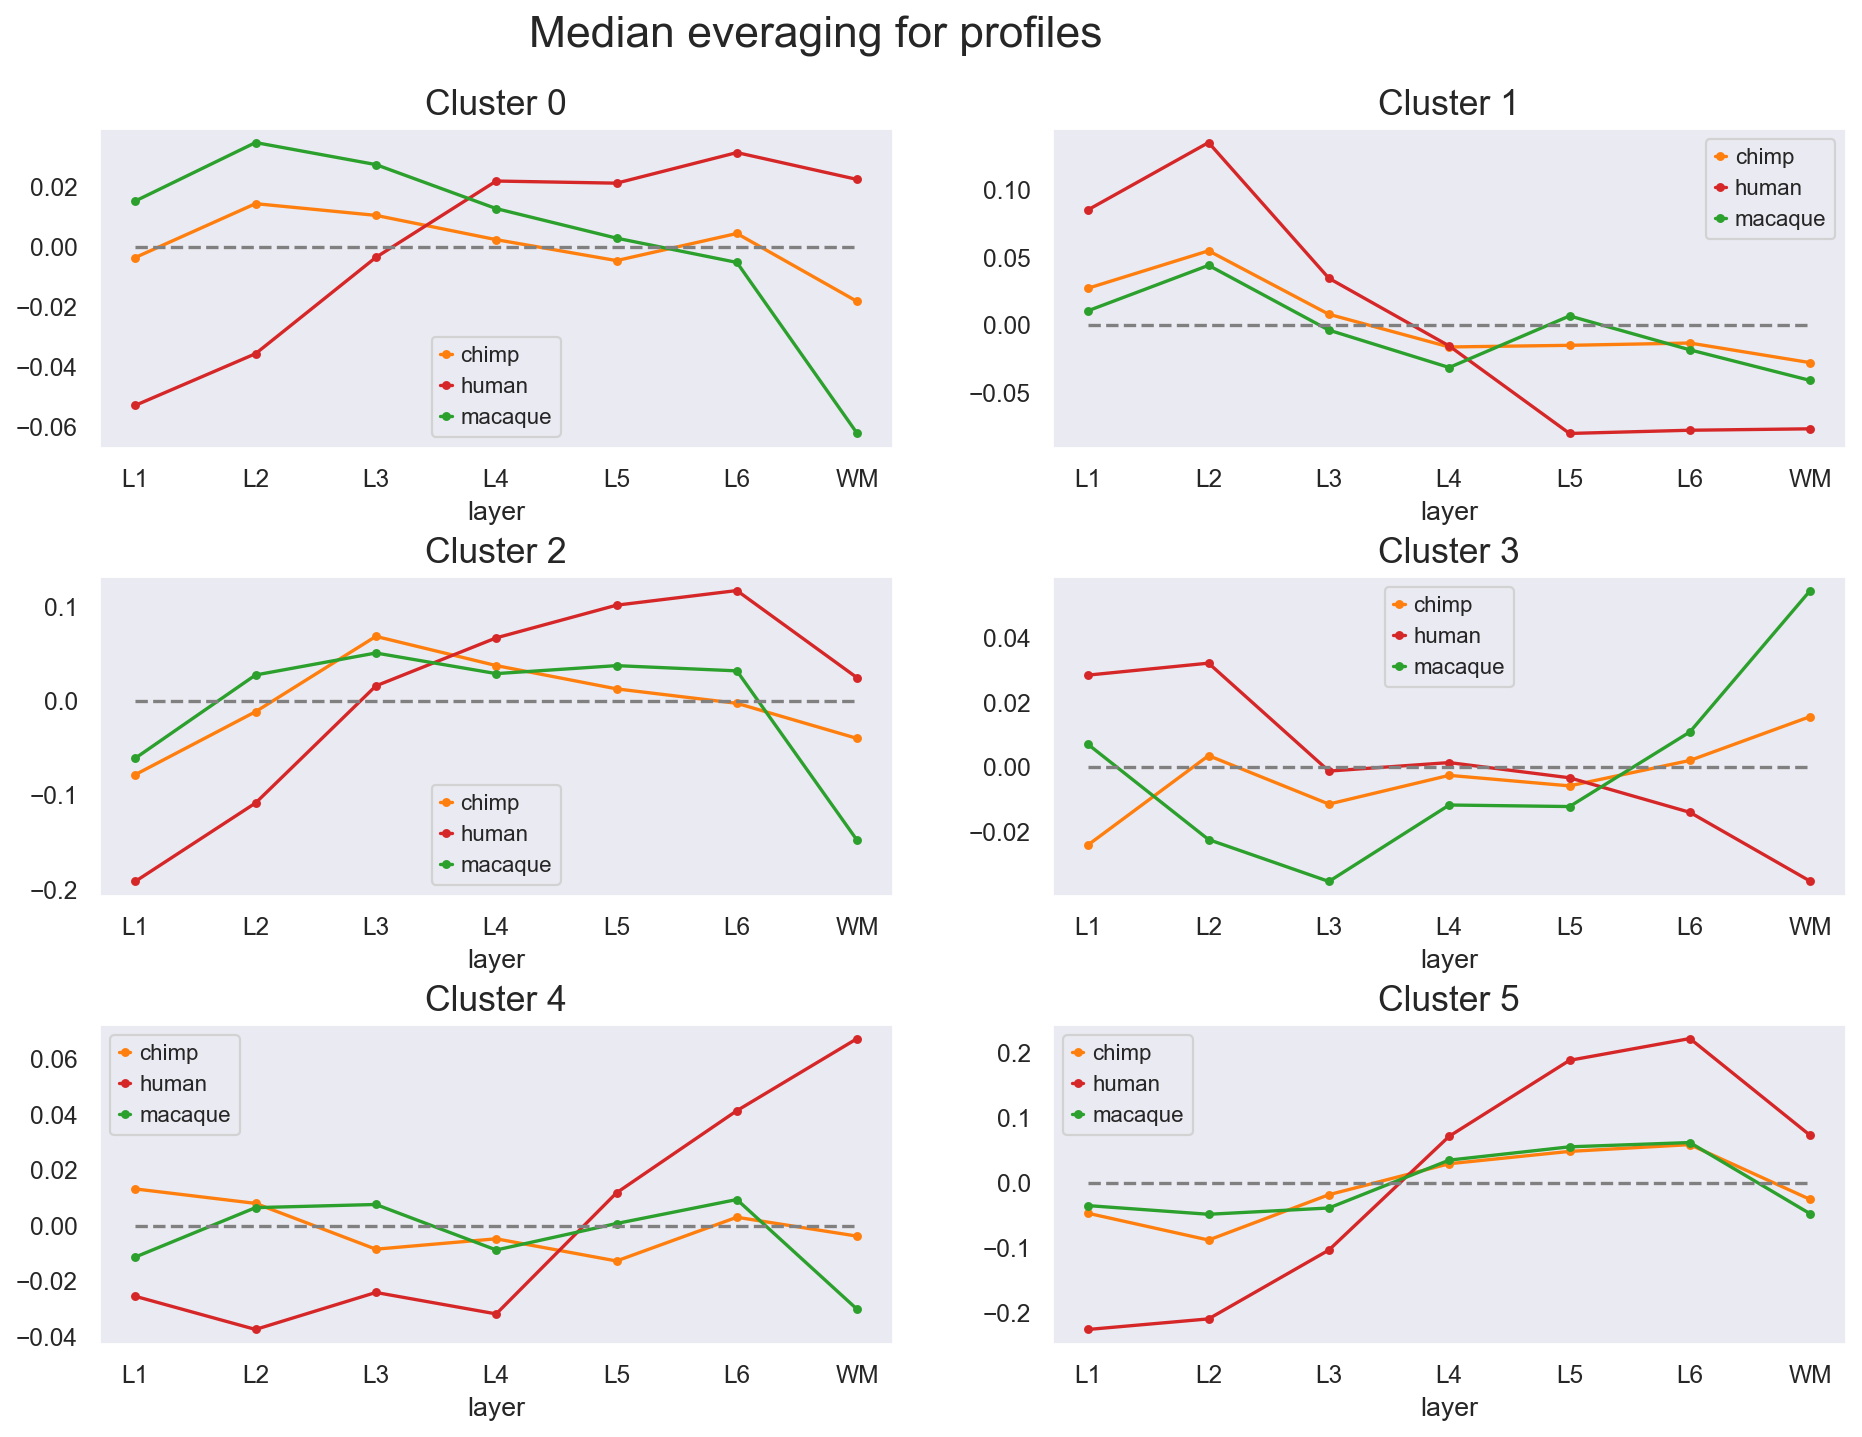

In [34]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# 4 Species

In [35]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [36]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [37]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

84

In [38]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [39]:
order_4spe = order.intersection(hs_genes_inter)

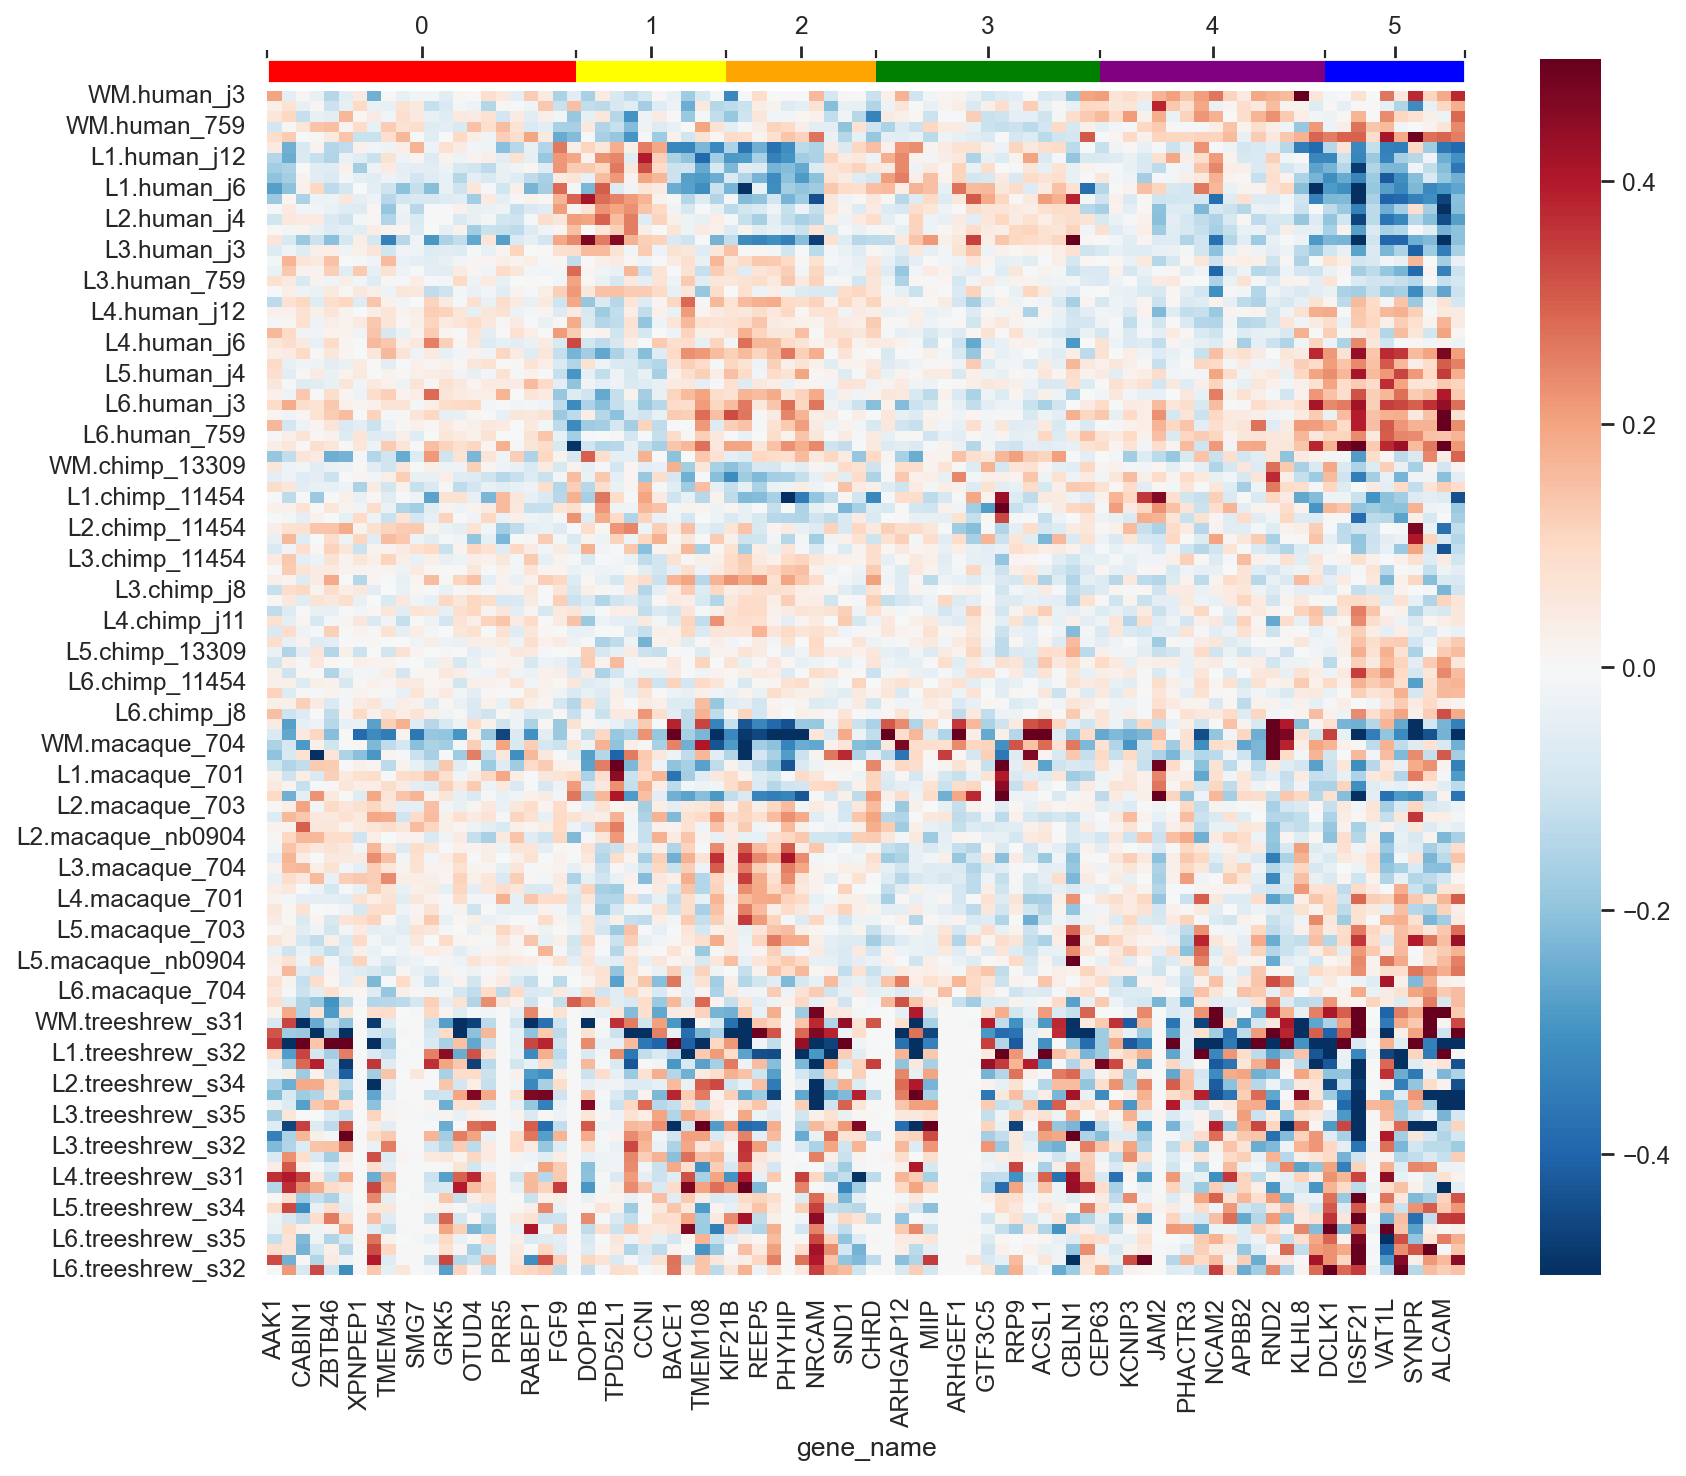

In [40]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [41]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [42]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          CLSTN1      MIIP    IGSF21    EIF4G3     DHDDS    TMEM54  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.204243 -0.089318 -0.231617 -0.038050  0.114089 -0.066698   
          L2    -0.104800  0.057920 -0.164320  0.012132 -0.030564  0.096026   
          L3     0.015519 -0.024564 -0.013440 -0.050283 -0.045656  0.030481   
          L4     0.085212  0.016214  0.176425  0.033634 -0.004315  0.009125   

gene_name           DMAP1     CADM3      COP1      SMG7  ...   ARHGEF1  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.073307 -0.009694 -0.052492 -0.097093  ...  0.015077   
          L2     0.064894  0.019649  0.048419  0.062498  ... -0.016554   
          L3    -0.035328  0.087419  0.016895  0.009346  ... -0.010182   
          L4    -0.033432  0.043859 -0.015726  0.021515  ... -0.043520   

gene_name            ETFB      GNAZ    CABIN1    ASPHD2      PRR5     NCAM2  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1     0.162136 -0.039300  0.007308 -0.039383  0.094752  0.075177   
          L2    -0.038228  0.123926  0.034510  0.071358 -0.154759  0.041594   
          L3    -0.048922  0.102861  0.015382  0.092665  0.030381 -0.014084   
          L4     0.016441  0.079627 -0.018344  0.007259  0.048155 -0.011287   

gene_name            JAM2     DOP1B     PSMG1  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.285189 -0.073972  0.045174  
          L2    -0.111063  0.095484 -0.007438  
          L3    -0.064058 -0.011986 -0.011472  
          L4    -0.068254 -0.084628 -0.036073  

[5 rows x 84 columns]

In [43]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

Text(0.5, 0.98, 'Mean everaging for profiles')

## Cluster profiles (Median)

In [44]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

Text(0.5, 0.98, 'Median everaging for profiles')

In [45]:
# sns.set(font_scale=1)
# label = 3
# genes = hs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('hs_genes_profiles.pdf')

In [46]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACTN2', 'ALKBH5', 'BOLA3', 'CYP26A1', 'DNAJC4', 'FOXN2', 'HSPB11',
        'LCMT1', 'LMO3', 'MRPL23', 'NUP93', 'PTOV1', 'PTP4A2', 'RING1', 'RRN3',
        'RSL24D1', 'SDCBP2', 'SEMA3A', 'SETD1B', 'SMARCA1', 'SULF1', 'TMCC2',
        'TMEM130', 'WDR37', 'WDR83', 'ZBTB17', 'ZFPL1'],
       dtype='object'),
 27)

In [47]:
cs_genes_inter = df_4spe.columns.intersection(cs_genes)
cs_genes_inter.size

15

In [48]:
df_4spe_cs = df_4spe[cs_genes_inter]

In [49]:
df_annotation = df_4spe_cs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [50]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          ZBTB17    PTP4A2     TMCC2     FOXN2    SEMA3A   TMEM130  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.050830  0.000890  0.090244  0.045546 -0.161038 -0.224421   
          L2    -0.031148  0.050531  0.029616  0.038166 -0.140664 -0.057074   
          L3    -0.019490  0.044331  0.110009 -0.021604  0.005594  0.014856   
          L4    -0.021841 -0.054662 -0.001428  0.002799  0.095570 -0.012603   

gene_name           SULF1     ZFPL1     WDR37    SETD1B     NUP93    ALKBH5  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.128867  0.137539 -0.098659 -0.086805  0.118650  0.020055   
          L2    -0.241896 -0.007468 -0.002663 -0.025815  0.011037 -0.059554   
          L3    -0.232210  0.033039 -0.043339 -0.028695  0.038760 -0.011210   
          L4    -0.218902 -0.070669  0.041455  0.010910 -0.023170 -0.062516   

gene_name          SDCBP2     WDR83     PTOV1  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.073358 -0.067069 -0.056096  
          L2     0.072865 -0.031798  0.023434  
          L3     0.034980 -0.007292  0.020639  
          L4     0.013691  0.018435 -0.029804

In [51]:
# sns.set(font_scale=1)
# label = 3
# genes = cs_genes_inter.tolist()
# fig, axes = plt.subplots((len(genes) + 1) // 2, 2,  figsize=(14, 3.5 * len(genes) // 2), gridspec_kw={'hspace': 0.4})

# for gene, ax in zip(genes, axes.flatten()):
#     (
#         layer_mean[gene]
#         .reorder_levels(['layer', 'condition'])
#         .unstack().loc[layers]
#         .plot
#         .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
#     )
#     ax.legend(fontsize=10)
#     ax.set_title(f'{gene}', fontsize=16)
#     ax.grid(False)
#     ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')
# plt.savefig('cs_genes_profiles.pdf')

# Intersection with ANOVA clusters

In [52]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['AAK1', 'ACSL1', 'AHI1', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2', 'ARHGAP12',
       'ARHGEF1', 'ASPHD2',
       ...
       'TMEM108', 'TMEM54', 'TMEM59L', 'TPD52L1', 'TSC22D1', 'VAT1L', 'VGLL4',
       'VPS51', 'YWHAE', 'ZBTB46'],
      dtype='object', length=111)

In [53]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2    3    4     5
ANOVA_labels                                  
0              1.0  11.0   0.0  4.0  0.0   0.0
1              3.0   1.0   0.0  2.0  4.0   1.0
2             10.0   0.0  10.0  0.0  2.0  14.0
3              0.0   0.0   1.0  7.0  3.0   0.0
4              0.0   2.0   0.0  5.0  3.0   0.0
5              8.0   1.0   5.0  0.0  2.0   0.0
6              1.0   0.0   0.0  1.0  9.0   0.0

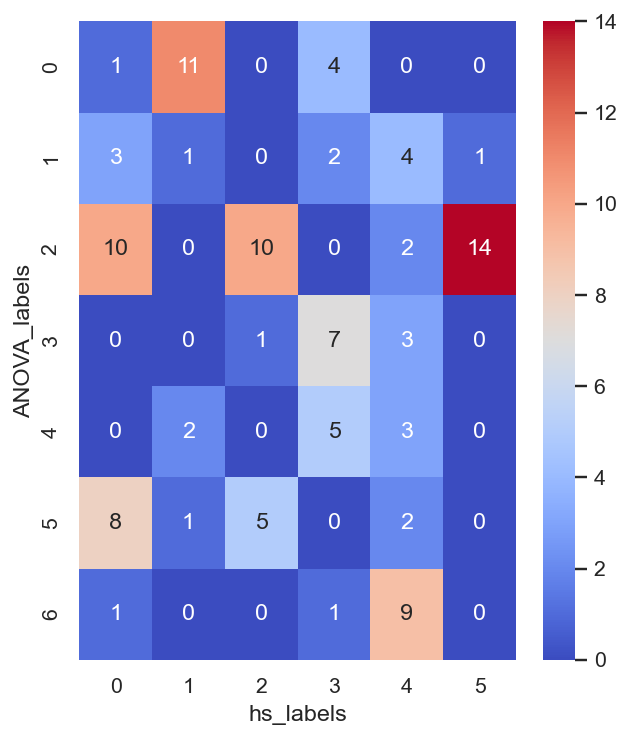

In [54]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

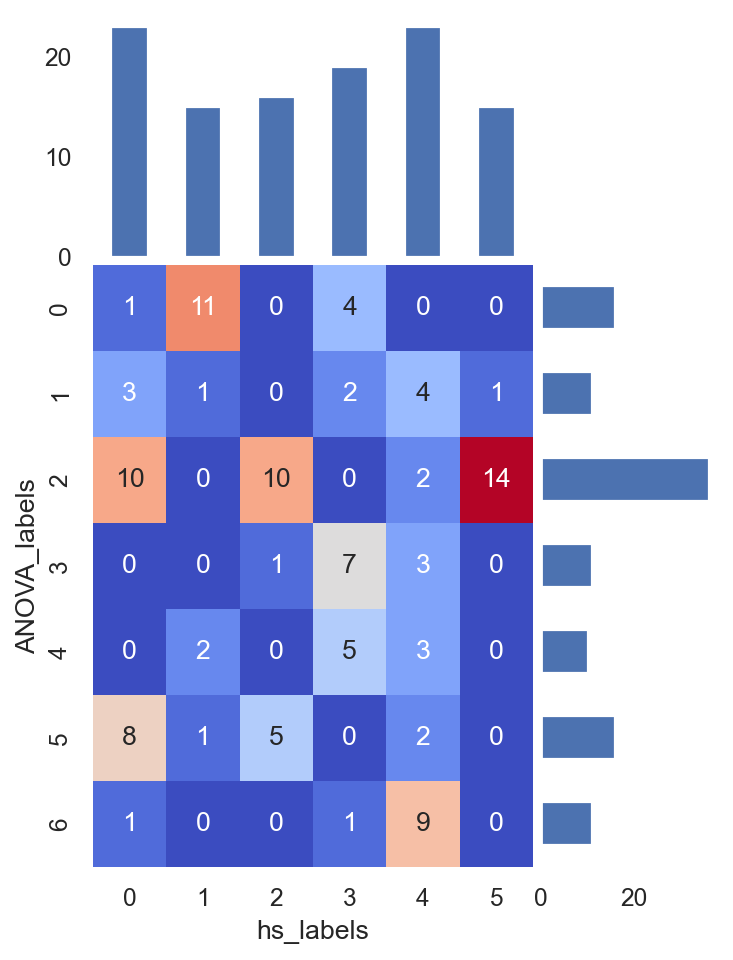

In [55]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [56]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/6 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [57]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [58]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
positive regulation of DNA demethylation (GO:19...     1  0.000109   
regulation of DNA demethylation (GO:1901535)           2  0.000109   
regulation of synaptic transmission, glutamater...     3  0.003632   
protein modification by small protein conjugati...     4  0.003960   
ubiquitin-dependent protein catabolic process (...     5  0.005990   

                                                       Z-score  \
Term                                                             
positive regulation of DNA demethylation (GO:19...  345.548387   
regulation of DNA demethylation (GO:1901535)        345.548387   
regulation of synaptic transmission, glutamater...   26.521092   
protein modification by small protein conjugati...    5.415622   
ubiquitin-dependent protein catabolic process (...    4.882842   

                                                    Combined score  \
Term                                                                 
positive regulation of DNA demethylation (GO:19...     3153.973197   
regulation of DNA demethylation (GO:1901535)           3153.973197   
regulation of synaptic transmission, glutamater...      148.997723   
protein modification by small protein conjugati...       29.956277   
ubiquitin-dependent protein catabolic process (...       24.988681   

                                                                         Overlapping genes  \
Term                                                                                         
positive regulation of DNA demethylation (GO:19...                          [OTUD4, USP9X]   
regulation of DNA demethylation (GO:1901535)                                [OTUD4, USP9X]   
regulation of synaptic transmission, glutamater...                          [ATAD1, NRXN1]   
protein modification by small protein conjugati...  [SELENOS, USP9X, FBXW11, HECW1, RNF40]   
ubiquitin-dependent protein catabolic process (...     [COP1, USP9X, FBXW11, HECW1, RNF40]   

                                                    Adjusted P-value  \
Term                                                                   
positive regulation of DNA demethylation (GO:19...          0.018035   
regulation of DNA demethylation (GO:1901535)                0.018035   
regulation of synaptic transmission, glutamater...          0.152046   
protein modification by small protein conjugati...          0.152046   
ubiquitin-dependent protein catabolic process (...          0.152046   

                                                    Old p-value  \
Term                                                              
positive regulation of DNA demethylation (GO:19...            0   
regulation of DNA demethylation (GO:1901535)                  0   
regulation of synaptic transmission, glutamater...            0   
protein modification by small protein conjugati...            0   
ubiquitin-dependent protein catabolic process (...            0   

                                                    Old adjusted p-value  \
Term                                                                       
positive regulation of DNA demethylation (GO:19...                     0   
regulation of DNA demethylation (GO:1901535)                           0   
regulation of synaptic transmission, glutamater...                     0   
protein modification by small protein conjugati...                     0   
ubiquitin-dependent protein catabolic process (...                     0   

                                                    num_overlap_genes  \
Term                                                                    
positive regulation of DNA demethylation (GO:19...                  2   
regulation of DNA demethylation (GO:1901535)                        2   
regulation of synaptic transmission, glutamater...                  2   
protein modification by small protein conjugati...                  5   
ub

In [59]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 15)].index.unique()
terms.size

19

In [60]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

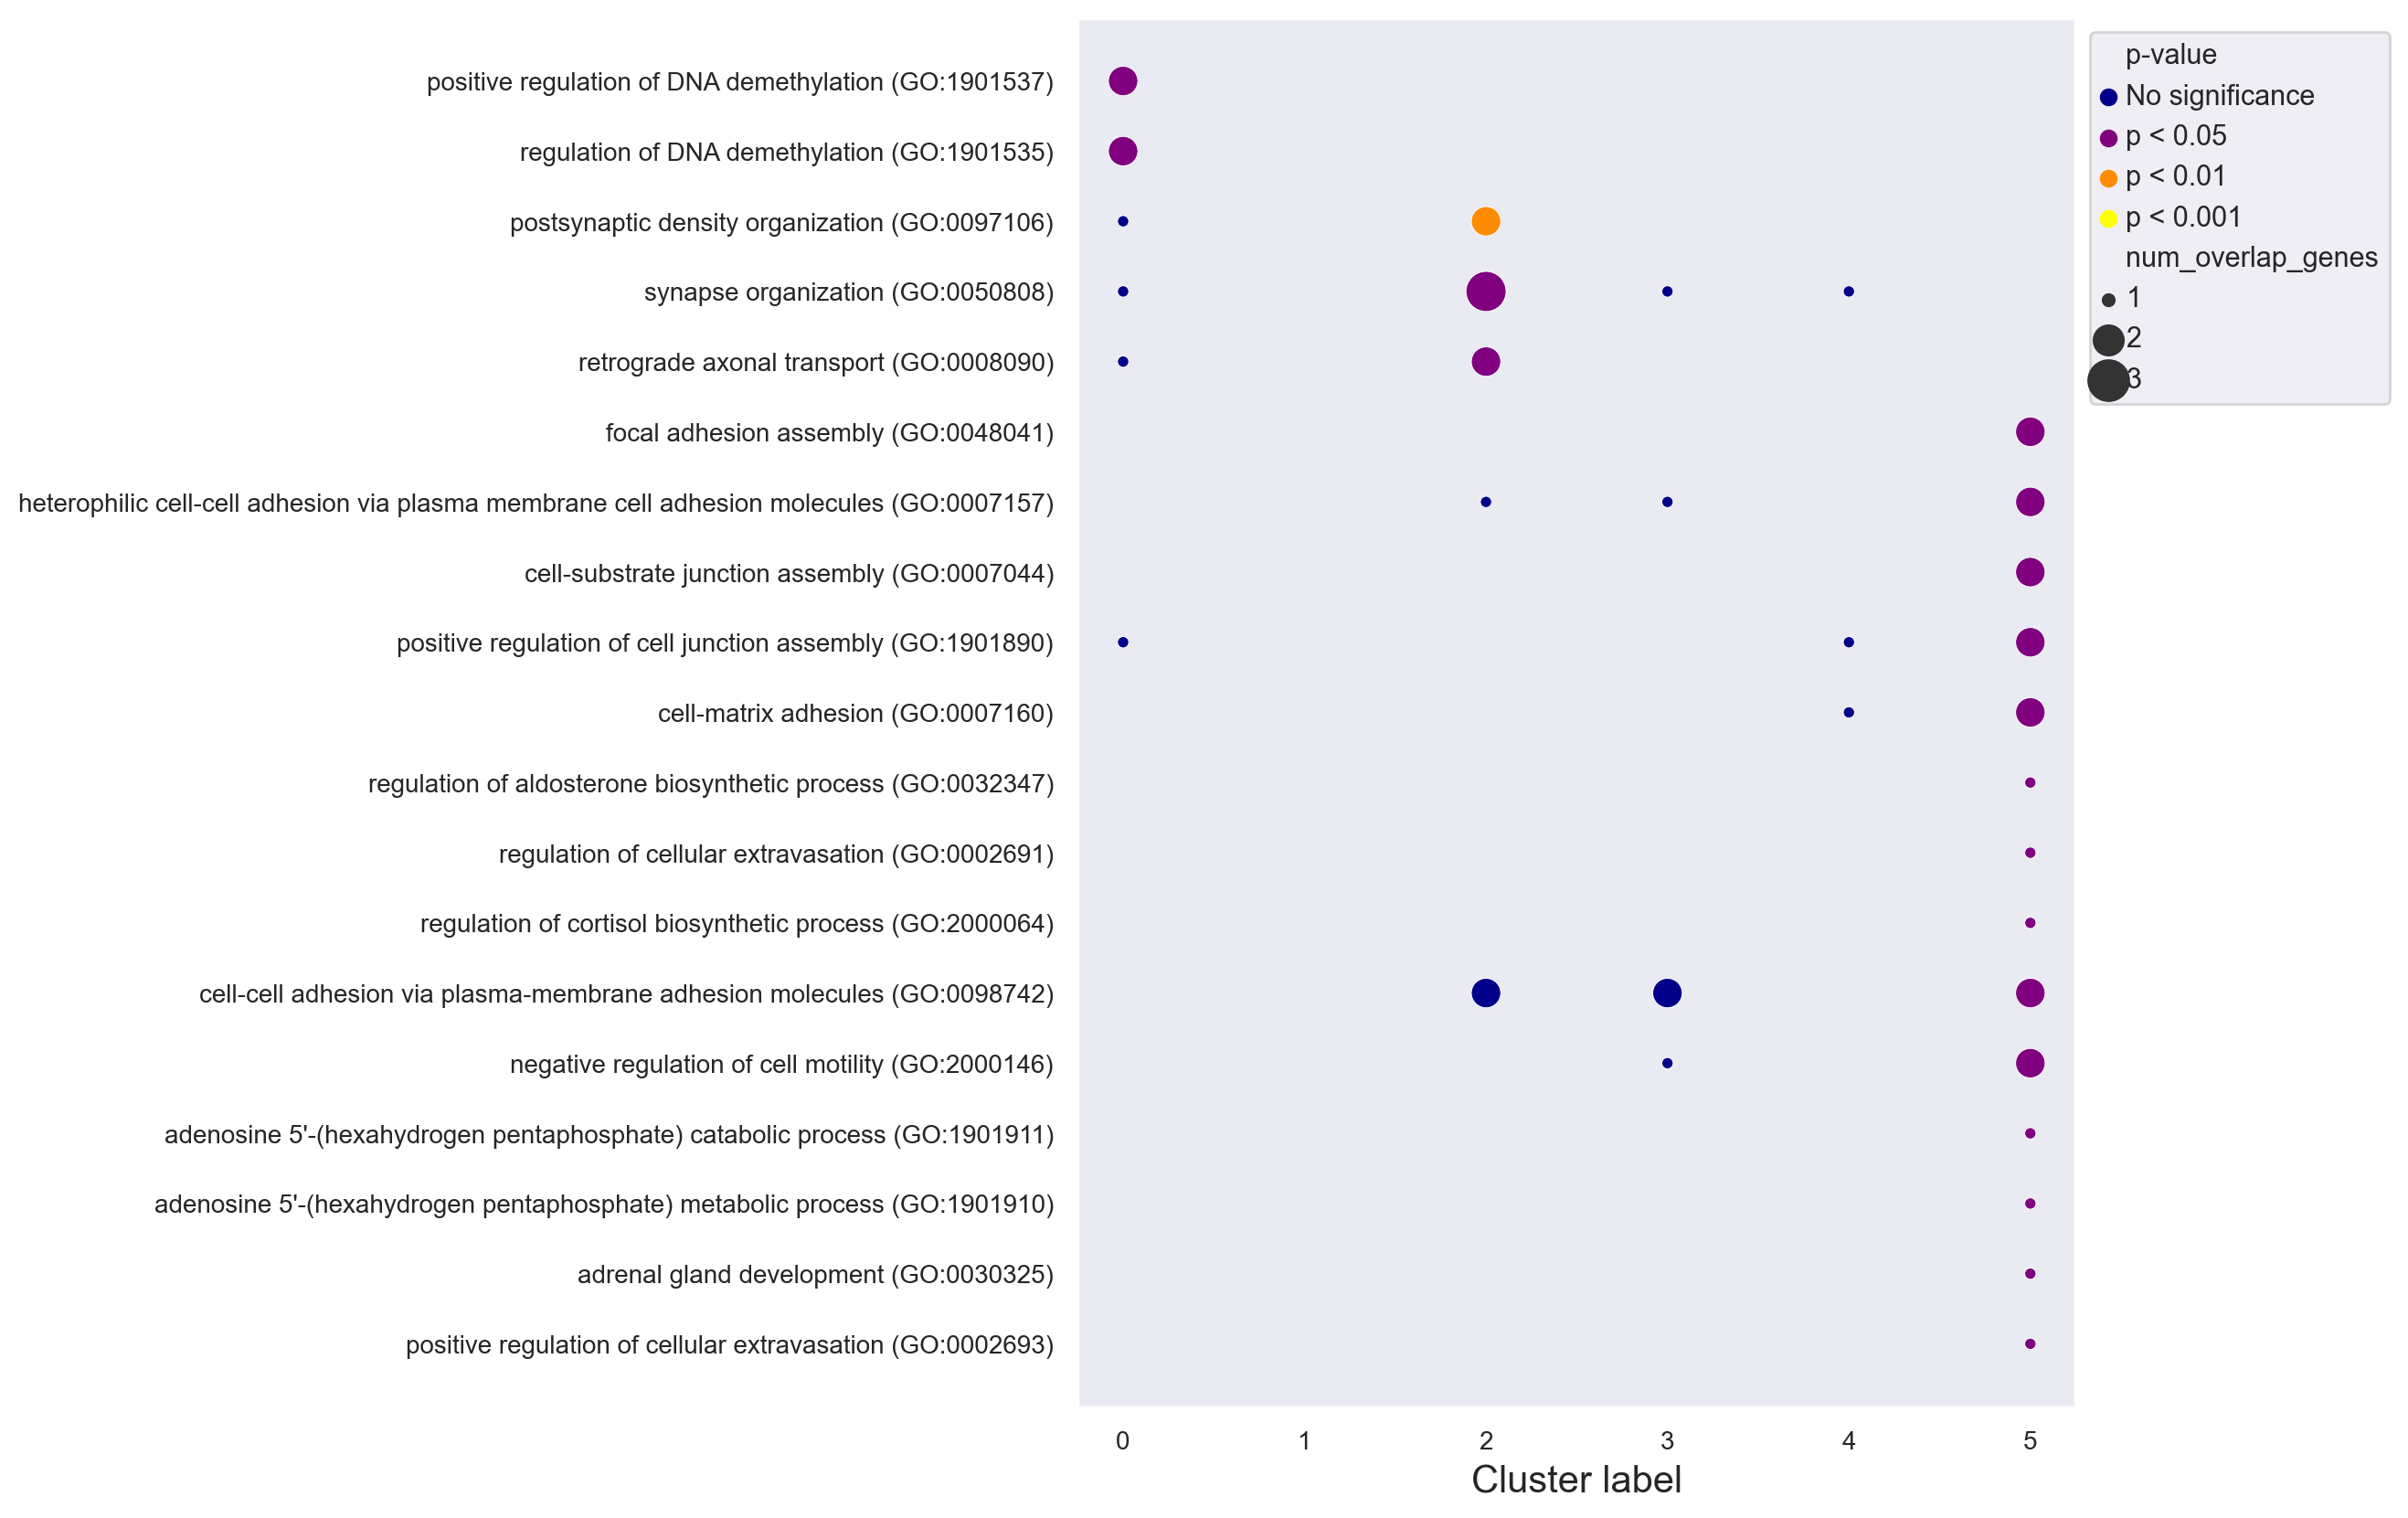

In [61]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [62]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [63]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Ionocyte CL0005006                                     1  0.006122   
Vip+ GABAergic Neuron 2 CL0000617                      2  0.018258   
Quiescent Stellate CL0002410                           1  0.005929   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...     2  0.005929   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...     3  0.008881   

                                                       Z-score  \
Term                                                             
Ionocyte CL0005006                                         inf   
Vip+ GABAergic Neuron 2 CL0000617                    83.671875   
Quiescent Stellate CL0002410                        358.200000   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...  358.200000   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...  179.066667   

                                                    Combined score  \
Term                                                                 
Ionocyte CL0005006                                             inf   
Vip+ GABAergic Neuron 2 CL0000617                       334.949639   
Quiescent Stellate CL0002410                           1836.838880   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...     1836.838880   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...      845.892192   

                                                   Overlapping genes  \
Term                                                                   
Ionocyte CL0005006                                           [PSMG1]   
Vip+ GABAergic Neuron 2 CL0000617                            [NRXN1]   
Quiescent Stellate CL0002410                                 [CSRP2]   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...            [ENC1]   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...            [ENC1]   

                                                    Adjusted P-value  \
Term                                                                   
Ionocyte CL0005006                                          0.012245   
Vip+ GABAergic Neuron 2 CL0000617                           0.018258   
Quiescent Stellate CL0002410                                0.008881   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...          0.008881   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...          0.008881   

                                                    Old p-value  \
Term                                                              
Ionocyte CL0005006                                            0   
Vip+ GABAergic Neuron 2 CL0000617                             0   
Quiescent Stellate CL0002410                                  0   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...            0   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Ionocyte CL0005006                                                     0   
Vip+ GABAergic Neuron 2 CL0000617                                      0   
Quiescent Stellate CL0002410                                           0   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...                     0   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Ionocyte CL0005006                                                  1   
Vip+ GABAergic Neuron 2 CL0000617                                   1   
Quiescent Stellate CL0002410                                        1   
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron ...                  1   
Layer 2-3 Glutamatergic Neuron, Intratelencepha...                  1   

                                                    neg_log10(p_adj)  \
Term      

In [64]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

26

In [65]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

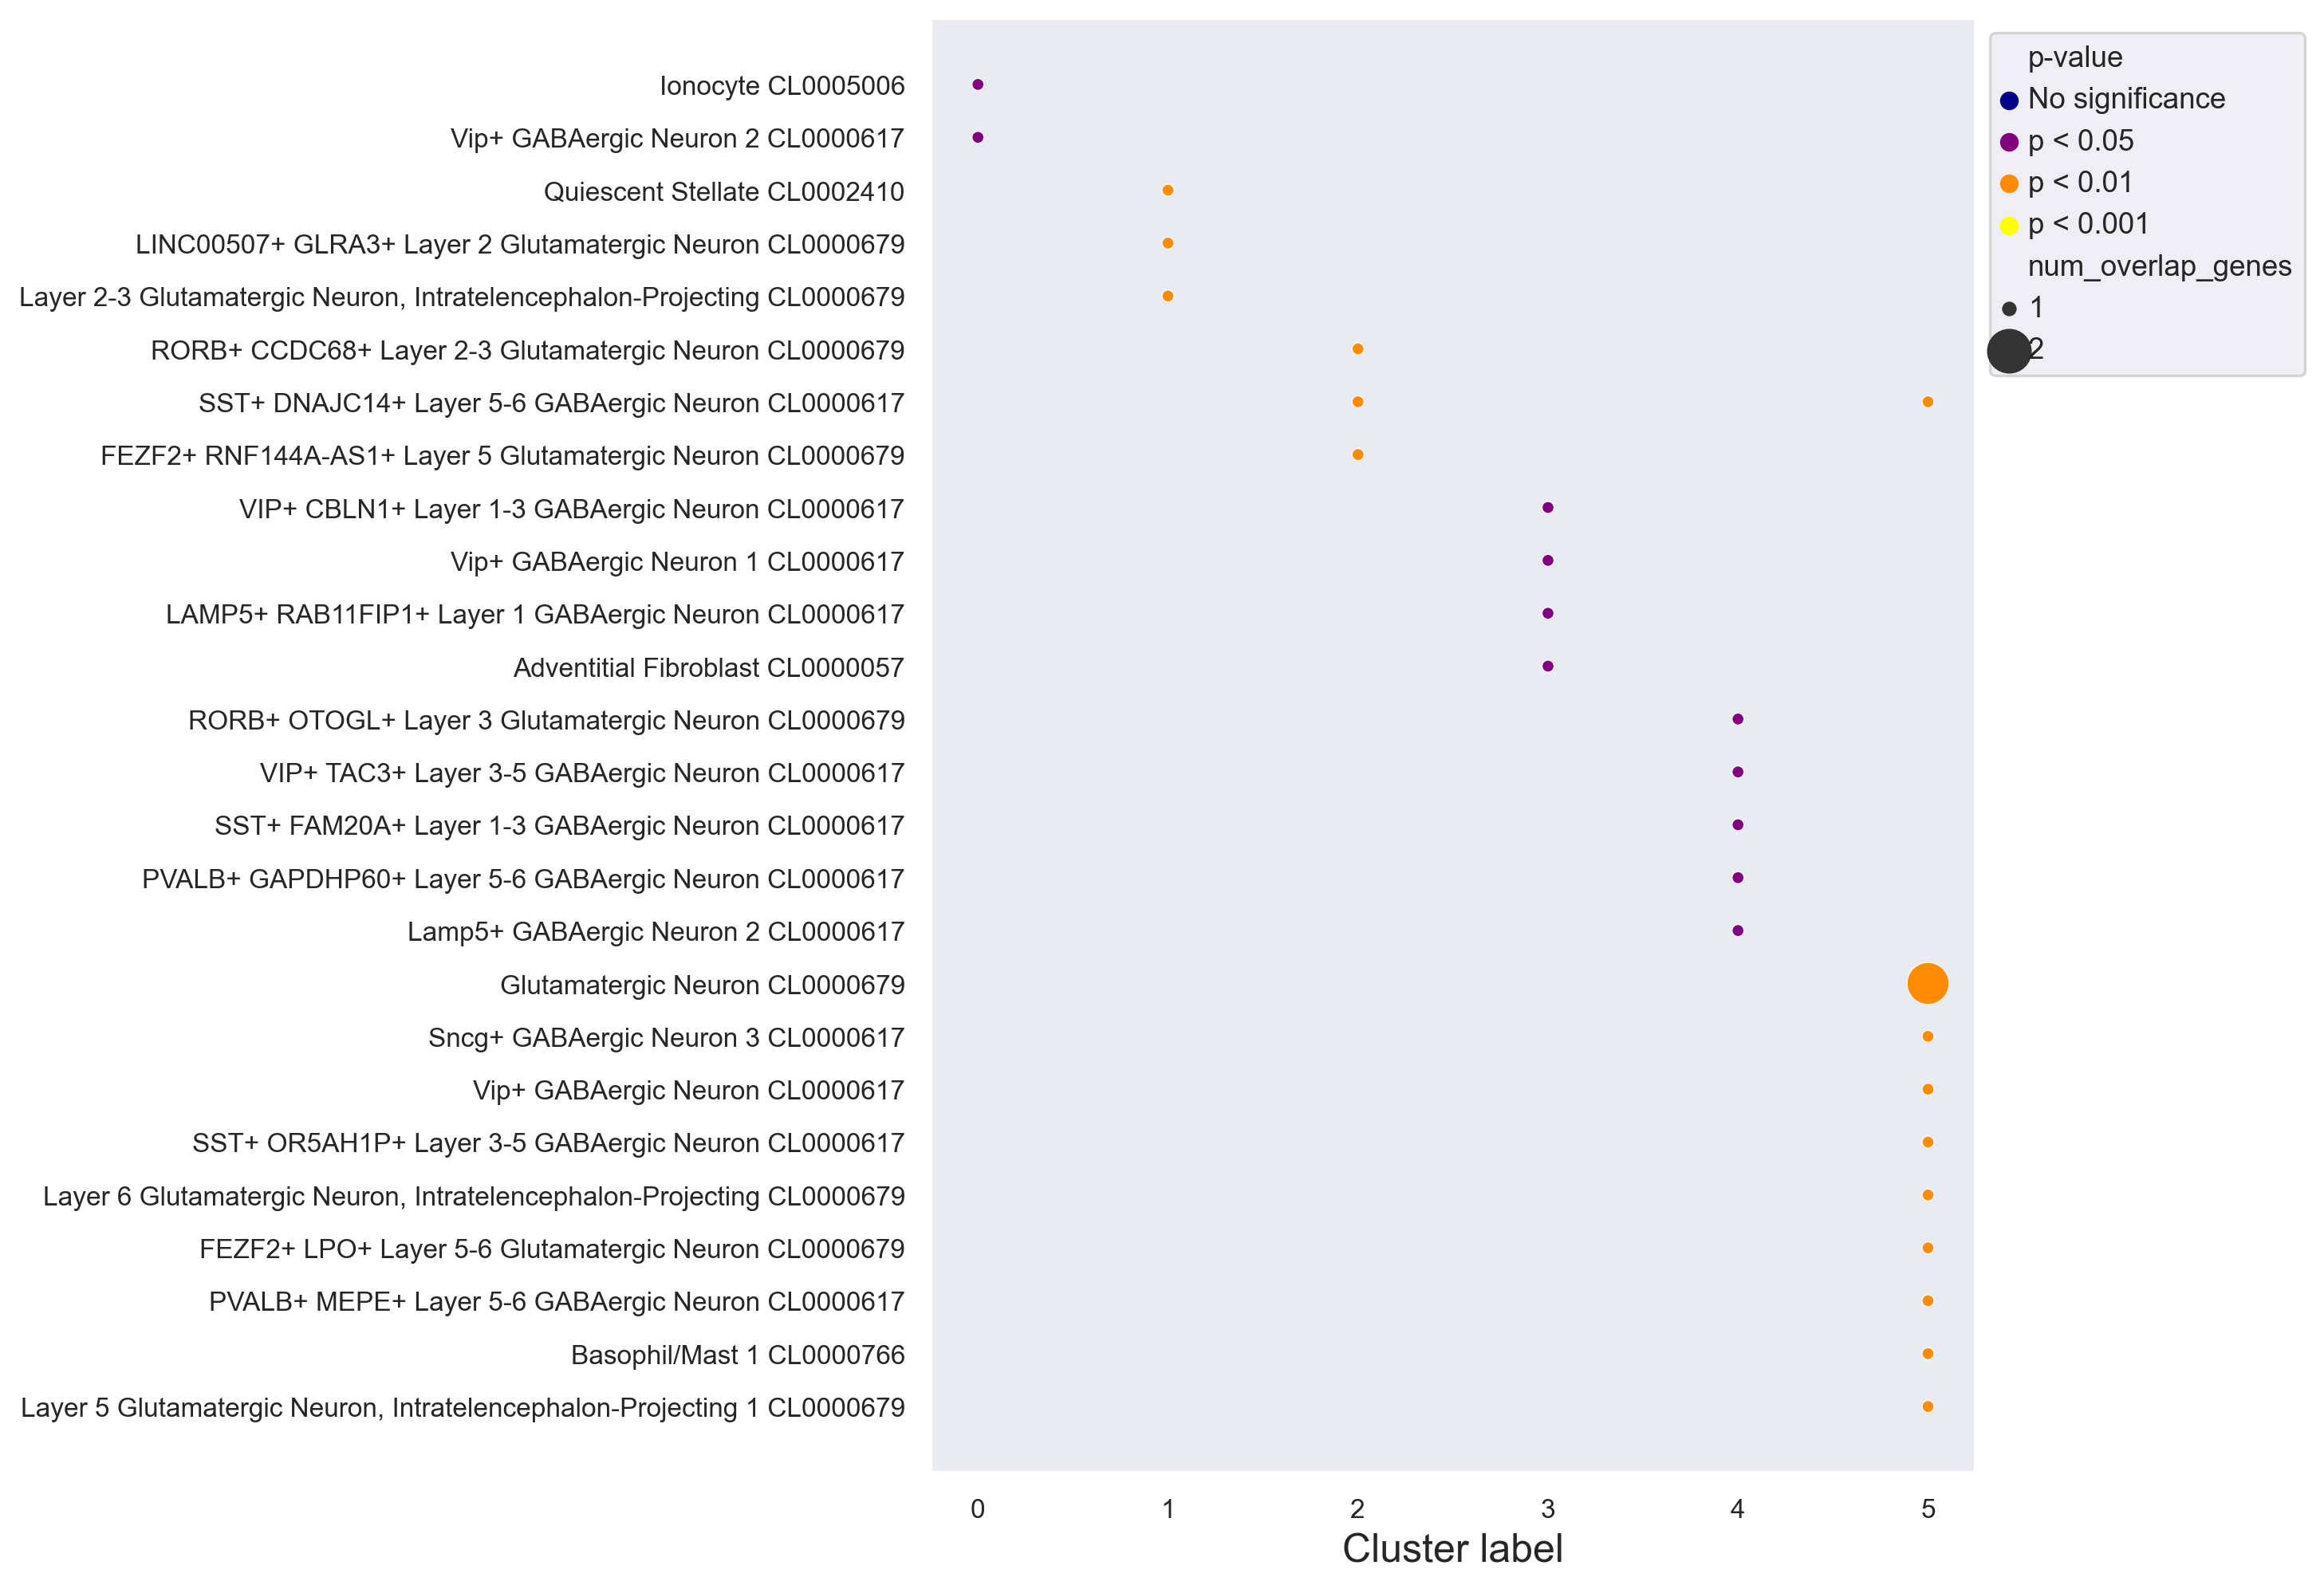

In [66]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [67]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [68]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
abnormal motor learning MP:0002804                     1  0.000388   
abnormal supraoccipital bone morphology MP:0000078     2  0.006122   
abnormal exoccipital bone morphology MP:0000080        3  0.006122   
short tibia MP:0002764                                 4  0.012054   
delayed kidney development MP:0000528                  5  0.012208   

                                                       Z-score  \
Term                                                             
abnormal motor learning MP:0002804                   25.409524   
abnormal supraoccipital bone morphology MP:0000078         inf   
abnormal exoccipital bone morphology MP:0000080            inf   
short tibia MP:0002764                                6.948684   
delayed kidney development MP:0000528               167.375000   

                                                    Combined score  \
Term                                                                 
abnormal motor learning MP:0002804                      199.594124   
abnormal supraoccipital bone morphology MP:0000078             inf   
abnormal exoccipital bone morphology MP:0000080                inf   
short tibia MP:0002764                                   30.701528   
delayed kidney development MP:0000528                   737.392110   

                                                       Overlapping genes  \
Term                                                                       
abnormal motor learning MP:0002804                  [STAU2, NRXN1, ELK1]   
abnormal supraoccipital bone morphology MP:0000078               [PCGF2]   
abnormal exoccipital bone morphology MP:0000080                  [PCGF2]   
short tibia MP:0002764                              [NRXN1, AAK1, RSPO2]   
delayed kidney development MP:0000528                            [RSPO2]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal motor learning MP:0002804                          0.074065   
abnormal supraoccipital bone morphology MP:0000078          0.152049   
abnormal exoccipital bone morphology MP:0000080             0.152049   
short tibia MP:0002764                                      0.152049   
delayed kidney development MP:0000528                       0.152049   

                                                    Old p-value  \
Term                                                              
abnormal motor learning MP:0002804                            0   
abnormal supraoccipital bone morphology MP:0000078            0   
abnormal exoccipital bone morphology MP:0000080               0   
short tibia MP:0002764                                        0   
delayed kidney development MP:0000528                         0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal motor learning MP:0002804                                     0   
abnormal supraoccipital bone morphology MP:0000078                     0   
abnormal exoccipital bone morphology MP:0000080                        0   
short tibia MP:0002764                                                 0   
delayed kidney development MP:0000528                                  0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal motor learning MP:0002804                                  3   
abnormal supraoccipital bone morphology MP:0000078                  1   
abnormal exoccipital bone morphology MP:0000080                     1   
short tibia MP:0002764                                              3   
delayed kidney development MP:0000528                               1   

                                                    ne

In [69]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

22

In [70]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

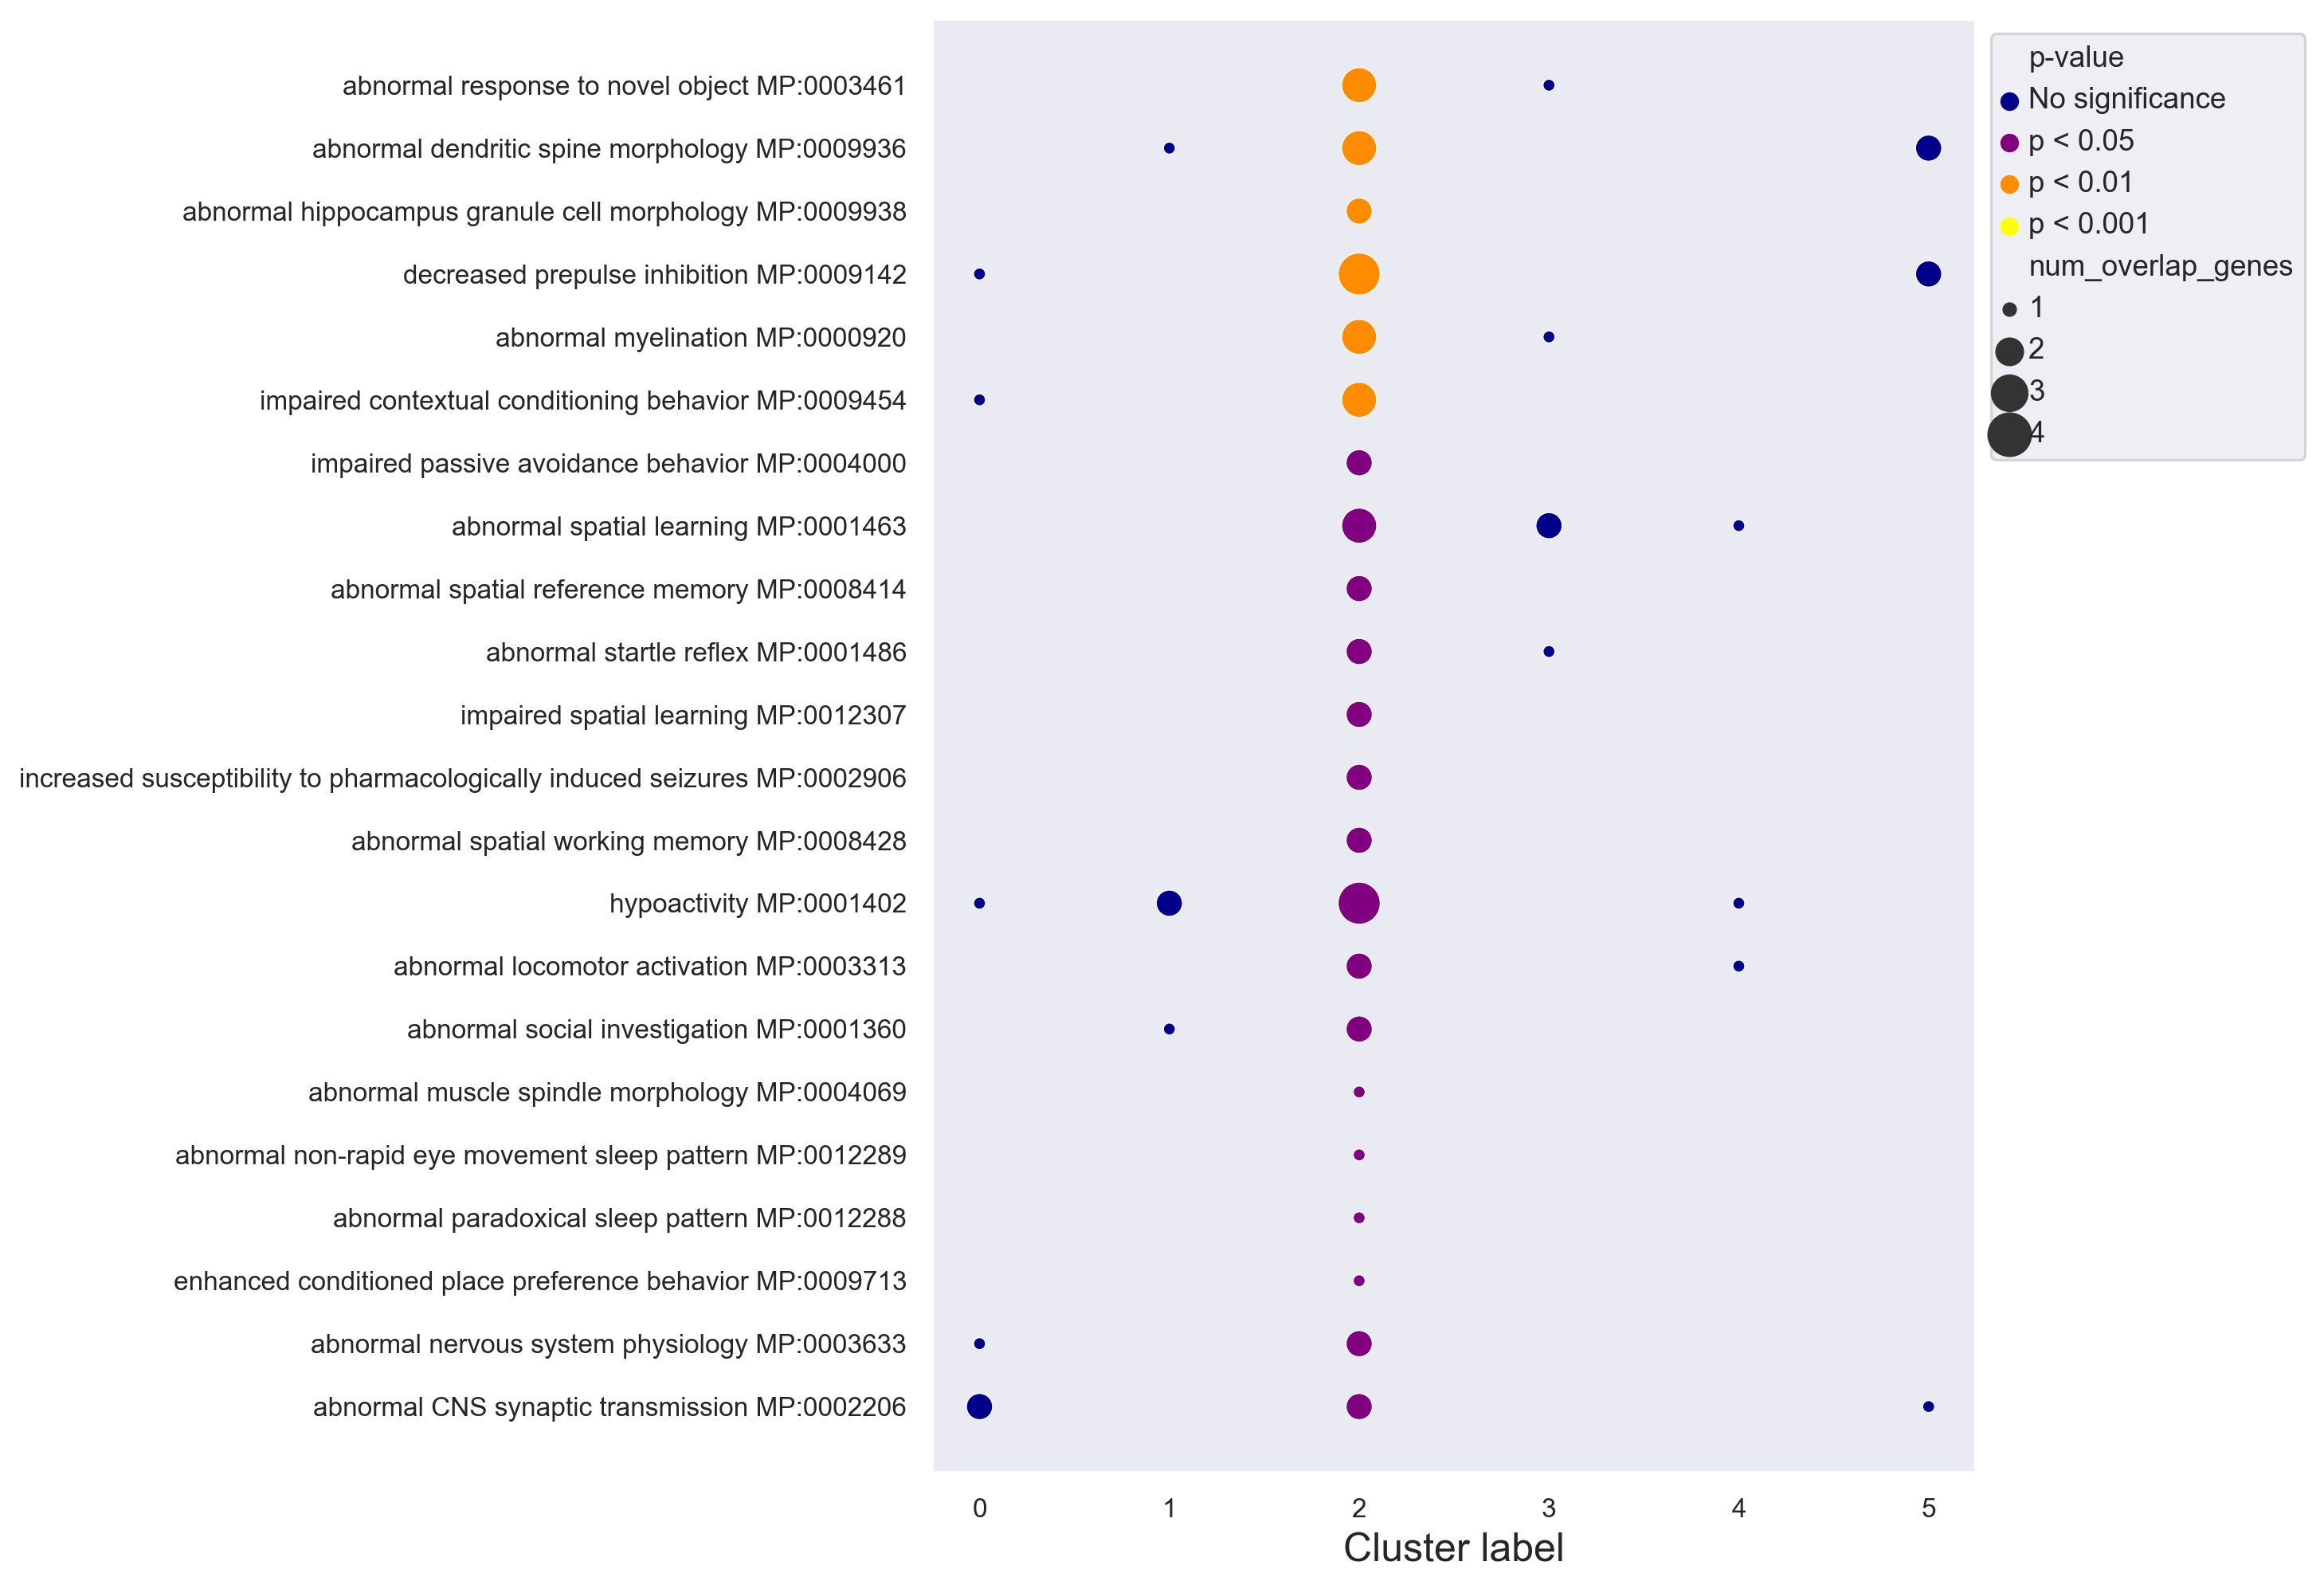

In [71]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [72]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [73]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  \
Term                                                                            
Protein Ubiquitination R-HSA-8852135                   1  0.002040  13.635897   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...     2  0.006122        inf   
Neurexins And Neuroligins R-HSA-6794361                3  0.007779  17.216129   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...     4  0.012441  13.228288   
OAS Antiviral Response R-HSA-8983711                   5  0.018258  83.671875   

                                                    Combined score  \
Term                                                                 
Protein Ubiquitination R-HSA-8852135                     84.468681   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...             inf   
Neurexins And Neuroligins R-HSA-6794361                  83.607974   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...       58.029496   
OAS Antiviral Response R-HSA-8983711                    334.949639   

                                                          Overlapping genes  \
Term                                                                          
Protein Ubiquitination R-HSA-8852135                [SELENOS, USP9X, RNF40]   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...                [TSC22D1]   
Neurexins And Neuroligins R-HSA-6794361                      [NRXN1, LIN7B]   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...         [SELENOS, RNF40]   
OAS Antiviral Response R-HSA-8983711                                [PDE12]   

                                                    Adjusted P-value  \
Term                                                                   
Protein Ubiquitination R-HSA-8852135                        0.306068   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...          0.349045   
Neurexins And Neuroligins R-HSA-6794361                     0.349045   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...          0.349045   
OAS Antiviral Response R-HSA-8983711                        0.349045   

                                                    Old p-value  \
Term                                                              
Protein Ubiquitination R-HSA-8852135                          0   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...            0   
Neurexins And Neuroligins R-HSA-6794361                       0   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...            0   
OAS Antiviral Response R-HSA-8983711                          0   

                                                    Old adjusted p-value  \
Term                                                                       
Protein Ubiquitination R-HSA-8852135                                   0   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...                     0   
Neurexins And Neuroligins R-HSA-6794361                                0   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...                     0   
OAS Antiviral Response R-HSA-8983711                                   0   

                                                    num_overlap_genes  \
Term                                                                    
Protein Ubiquitination R-HSA-8852135                                3   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...                  1   
Neurexins And Neuroligins R-HSA-6794361                             2   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...                  2   
OAS Antiviral Response R-HSA-8983711                                1   

                                                    neg_log10(p_adj)  \
Term                                                                   
Protein Ubiquitination R-HSA-8852135                        0.514181   
POU5F1 (OCT4), SOX2, NANOG Repress Genes Relate...          0.457118   
Neurexins And Neuroligins R-HSA-6794361                     0.457118   
E3 Ubiquitin Ligases Ubiquitinate Target Protei...         

In [74]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0

In [75]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\aleks\AppData\Local\Temp\ipykernel_28360\3967478431.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


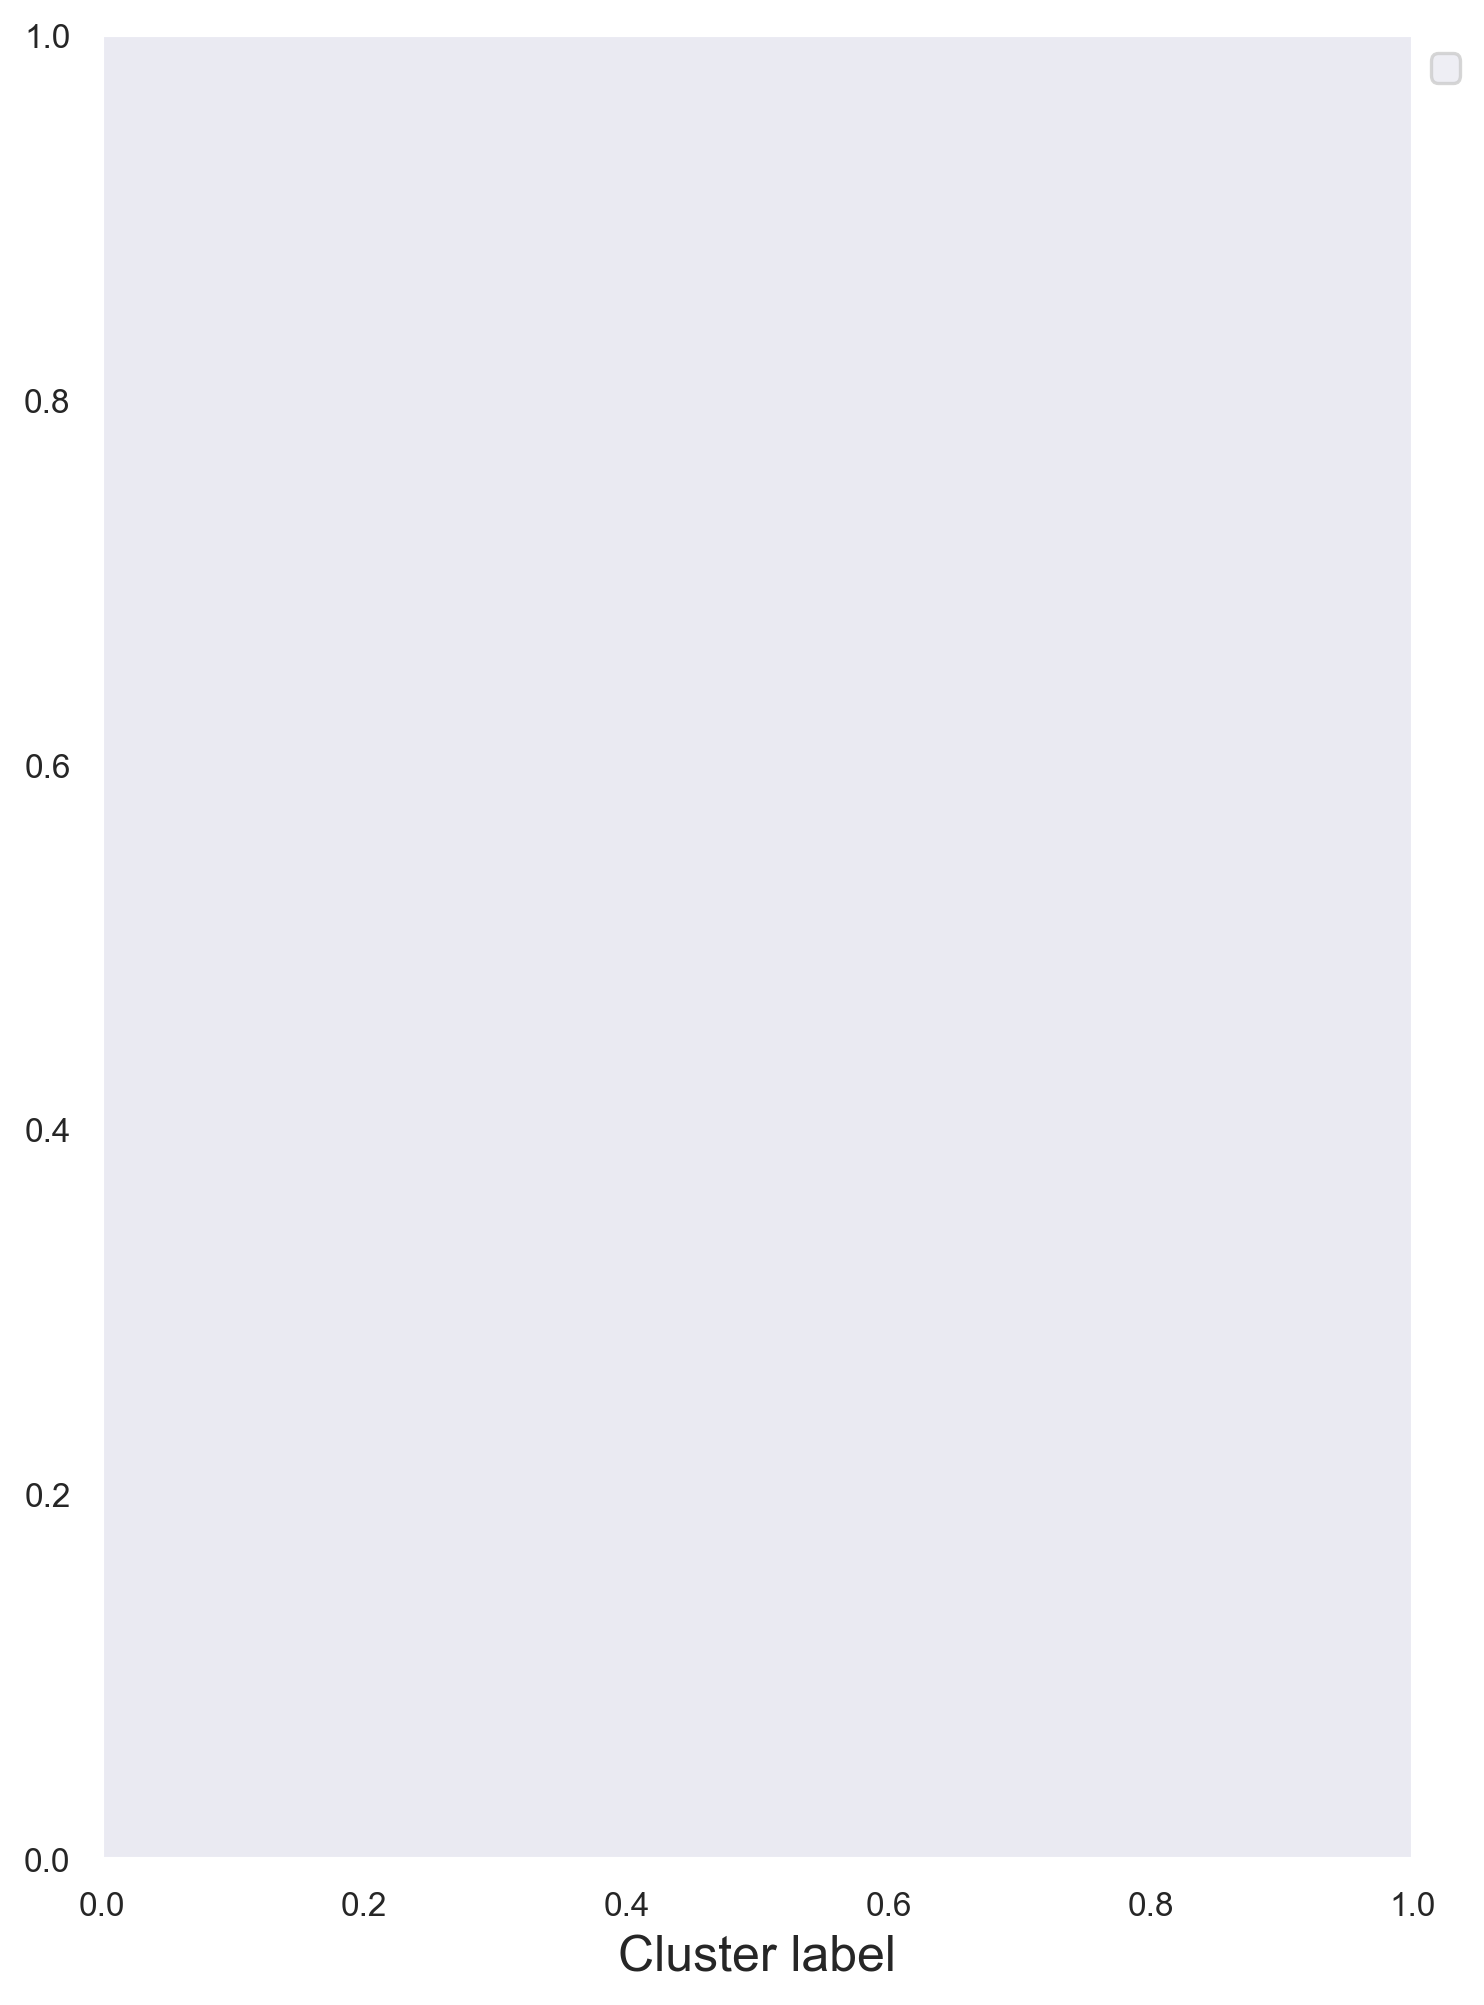

In [76]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [77]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [78]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val   Z-score  Combined score  \
Term                                                                  
Oocyte meiosis                1  0.033103  7.615771       25.955571   
Hippo signaling pathway       2  0.037090  7.135753       23.508162   
Wnt signaling pathway         3  0.037090  7.135753       23.508162   
mRNA surveillance pathway     4  0.038458  6.988808       22.770873   
Cellular senescence           5  0.039846  6.847742       22.068531   

                          Overlapping genes  Adjusted P-value  Old p-value  \
Term                                                                         
Oocyte meiosis             [PPP1CB, FBXW11]          0.292645            0   
Hippo signaling pathway    [PPP1CB, FBXW11]          0.292645            0   
Wnt signaling pathway       [FBXW11, RSPO2]          0.292645            0   
mRNA surveillance pathway    [PPP1CB, SMG7]          0.292645            0   
Cellular senescence        [PPP1CB, FBXW11]          0.292645            0   

                           Old adjusted p-value  num_overlap_genes  \
Term                                                                 
Oocyte meiosis                                0                  2   
Hippo signaling pathway                       0                  2   
Wnt signaling pathway                         0                  2   
mRNA surveillance pathway                     0                  2   
Cellular senescence                           0                  2   

                           neg_log10(p_adj)  cluster_label  
Term                                                        
Oocyte meiosis                     0.533659              0  
Hippo signaling pathway            0.533659              0  
Wnt signaling pathway              0.533659              0  
mRNA surveillance pathway          0.533659              0  
Cellular senescence                0.533659              0

In [79]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

3

In [80]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

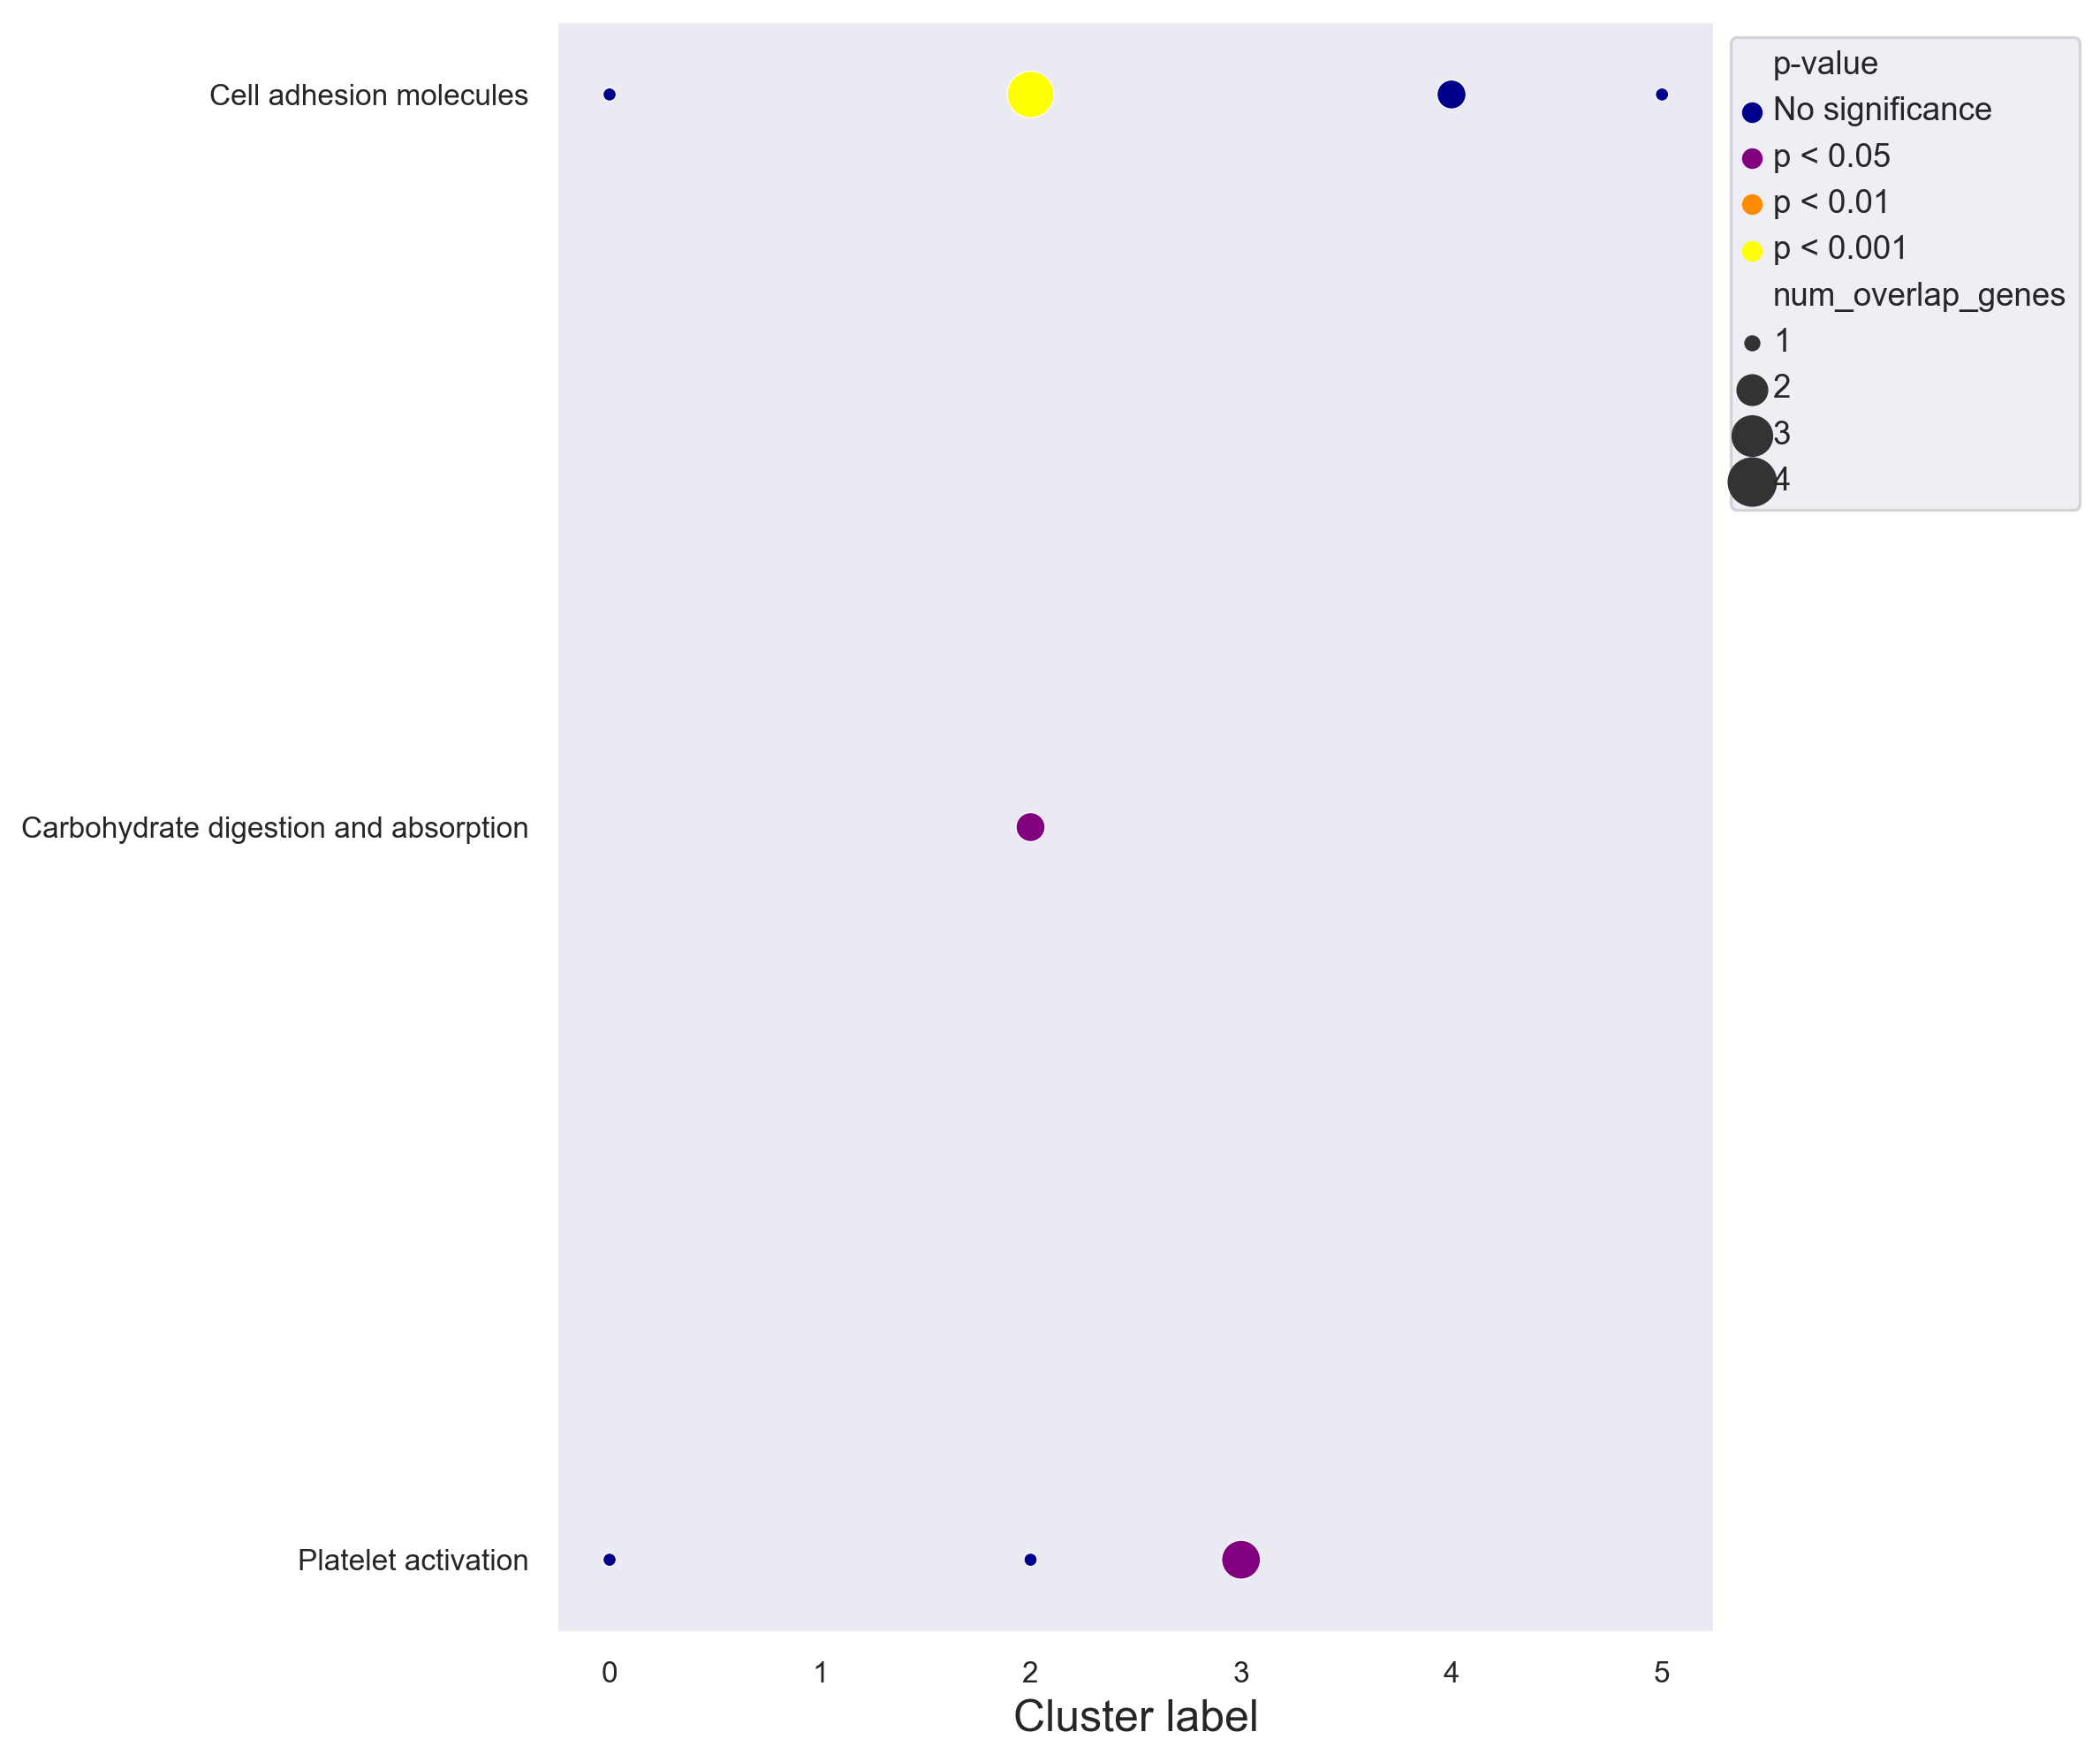

In [81]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))